# Optimising cluster shape properties with new algorithm

This algorithm uses triangles of different sizes:

1. P0113
2. P016
3. P03
4. P045

Together with the generator level information, we will use these three different sizes for three different studies and try to understand the impact of granularity on cluster properties.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import shap
from pathlib import Path
from itertools import cycle
from matplotlib.lines import Line2D
import matplotlib as mpl

In [3]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

### Path to the files

In [4]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgogen_filtered.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_Ref_filtered.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p0113_filtered.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p016_filtered.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p03_filtered.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p045_filtered.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogen_filtered.h5"
qcd_PU200_genpart = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogenpart_filtered.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_Ref_filtered.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p0113_filtered.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p016_filtered.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p03_filtered.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p045_filtered.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgogen_filtered.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_Ref_filtered.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p0113_filtered.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p016_filtered.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p03_filtered.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p045_filtered.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_Ref_filtered.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p0113_filtered.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p016_filtered.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p03_filtered.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p045_filtered.h5"

In [5]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [6]:
print(photon_df_p03.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p03Tri_pt', 'cl3d_p03Tri_energy', 'cl3d_p03Tri_eta', 'cl3d_p03Tri_phi', 'cl3d_p03Tri_showerlength', 'cl3d_p03Tri_coreshowerlength', 'cl3d_p03Tri_firstlayer', 'cl3d_p03Tri_maxlayer', 'cl3d_p03Tri_varrr', 'cl3d_p03Tri_varzz', 'cl3d_p03Tri_varee', 'cl3d_p03Tri_varpp', 'cl3d_p03Tri_emaxe', 'cl3d_p03Tri_hoe', 'cl3d_p03Tri_meanz', 'cl3d_p03Tri_first1layers', 'cl3d_p03Tri_first3layers', 'cl3d_p03Tri_first5layers', 'cl3d_p03Tri_firstHcal1layers', 'cl3d_p03Tri_firstHcal3layers', 'cl3d_p03Tri_firstHcal5layers', 'cl3d_p03Tri_last1layers', 'cl3d_p03Tri_last3layers', 'cl3d_p03Tri_last5layers', 'cl3d_p03Tri_emax1layers', 'cl3d_p03Tri_emax3layers', 'cl3d_p03Tri_emax5layers', 'cl3d_p03Tri_eot', 'cl3d_p03Tri_ebm0', 'cl3d_p03Tri_ebm1', 'cl3d_p03Tri_hbm']


In [7]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [8]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [9]:
print(pion_df_p016.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p016Tri_pt', 'cl3d_p016Tri_energy', 'cl3d_p016Tri_eta', 'cl3d_p016Tri_phi', 'cl3d_p016Tri_showerlength', 'cl3d_p016Tri_coreshowerlength', 'cl3d_p016Tri_firstlayer', 'cl3d_p016Tri_maxlayer', 'cl3d_p016Tri_varrr', 'cl3d_p016Tri_varzz', 'cl3d_p016Tri_varee', 'cl3d_p016Tri_varpp', 'cl3d_p016Tri_emaxe', 'cl3d_p016Tri_hoe', 'cl3d_p016Tri_meanz', 'cl3d_p016Tri_first1layers', 'cl3d_p016Tri_first3layers', 'cl3d_p016Tri_first5layers', 'cl3d_p016Tri_firstHcal1layers', 'cl3d_p016Tri_firstHcal3layers', 'cl3d_p016Tri_firstHcal5layers', 'cl3d_p016Tri_last1layers', 'cl3d_p016Tri_last3layers', 'cl3d_p016Tri_last5layers', 'cl3d_p016Tri_emax1layers', 'cl3d_p016Tri_emax3layers', 'cl3d_p016Tri_emax5layers', 'cl3d_p016Tri_eot', 'cl3d_p016Tri_ebm0', 'cl3d_p016Tri_ebm1', 'cl3d_p016Tri_hbm']


In [10]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

### Until this point, it is evident that with coarser granularity, the number of clusters increase!
This is an expected behaviour as lower triangle sizes removes clusters from pile-up!

In [11]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.5)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.5)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.5)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.5)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.5)

In [12]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.1)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.1)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.1)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.1)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.1)

In [13]:
photon_df_Ref_filtered = ana.filter_by_delta_r(photon_df_Ref, "cl3d_Ref", 0.05)
photon_df_p0113_filtered = ana.filter_by_delta_r(photon_df_p0113, "cl3d_p0113Tri", 0.05)
photon_df_p016_filtered = ana.filter_by_delta_r(photon_df_p016, "cl3d_p016Tri", 0.05)
photon_df_p03_filtered = ana.filter_by_delta_r(photon_df_p03, "cl3d_p03Tri", 0.05)
photon_df_p045_filtered = ana.filter_by_delta_r(photon_df_p045, "cl3d_p045Tri", 0.05)

## Let's begin the multi-class BDT

In [62]:
# Ref
photon_df_Ref_filtered['label'] = 0
pion_df_Ref_filtered['label'] = 3
qcd_df_Ref_filtered['label'] = 2
PU_df_Ref['label'] = 1
'''
# p0113
photon_df_p0113_filtered['label'] = 0
pion_df_p0113_filtered['label'] = 3
qcd_df_p0113_filtered['label'] = 2
PU_df_p0113['label'] = 1

# p016
photon_df_p016_filtered['label'] = 0
pion_df_p016_filtered['label'] = 3
qcd_df_p016_filtered['label'] = 2
PU_df_p016['label'] = 1

# p03
photon_df_p03_filtered['label'] = 0
pion_df_p03_filtered['label'] = 3
qcd_df_p03_filtered['label'] = 2
PU_df_p03['label'] = 1

# p045
photon_df_p045_filtered['label'] = 0
pion_df_p045_filtered['label'] = 3
qcd_df_p045_filtered['label'] = 2
PU_df_p045['label'] = 1'''

"\n# p0113\nphoton_df_p0113_filtered['label'] = 0\npion_df_p0113_filtered['label'] = 3\nqcd_df_p0113_filtered['label'] = 2\nPU_df_p0113['label'] = 1\n\n# p016\nphoton_df_p016_filtered['label'] = 0\npion_df_p016_filtered['label'] = 3\nqcd_df_p016_filtered['label'] = 2\nPU_df_p016['label'] = 1\n\n# p03\nphoton_df_p03_filtered['label'] = 0\npion_df_p03_filtered['label'] = 3\nqcd_df_p03_filtered['label'] = 2\nPU_df_p03['label'] = 1\n\n# p045\nphoton_df_p045_filtered['label'] = 0\npion_df_p045_filtered['label'] = 3\nqcd_df_p045_filtered['label'] = 2\nPU_df_p045['label'] = 1"

In [63]:
all_dfs = [qcd_df_Ref_filtered, photon_df_Ref_filtered, PU_df_Ref, pion_df_Ref_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('Ref') + ['label']]

In [64]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [65]:
X = df_combined[ana.columns_for_training('Ref')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [66]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [67]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [68]:
model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [69]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2, 3]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.915
🔢 Confusion Matrix:
 [[ 4328    29    79    15]
 [  193 18358   453   999]
 [   89    72  2363    86]
 [   36    52   326  1165]]
📈 ROC AUC (OvR): 0.978


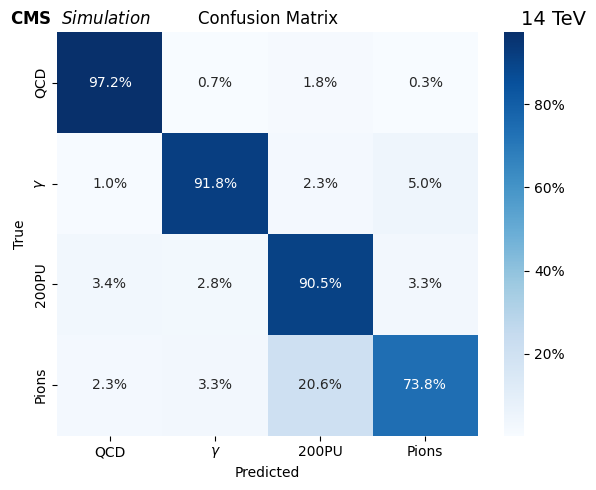

In [70]:
# Row-normalize to percentages
class_names = ['QCD', r'$\gamma$', '200PU', 'Pions']
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_pct = np.divide(conf_mat, row_sums, out=np.zeros_like(conf_mat), where=row_sums!=0) * 100.0

# Make pretty percent labels
annot_labels = np.array([[f"{v:.1f}%" for v in row] for row in conf_mat_pct])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_pct, annot=annot_labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"format": '%.0f%%'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
fig = plt.gcf()
plt.subplots_adjust(top=0.98, right=0.95)
fig.text(0.02, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.98, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.tight_layout()
plt.savefig("newsamples_Ref_plots/confusion_matrix.pdf")
plt.show()

In [71]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Normalise by true class totals (row-wise)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=[0, 1, 2, 3]),
    y_pred_proba,
    multi_class='ovr'
)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("🔢 Normalised Confusion Matrix (%):\n", np.round(conf_mat_norm, 2))
print(f"📈 ROC AUC (OvR): {roc_auc*100:.2f}%")


✅ Accuracy: 91.52%
🔢 Normalised Confusion Matrix (%):
 [[97.24  0.65  1.77  0.34]
 [ 0.96 91.78  2.26  4.99]
 [ 3.41  2.76 90.54  3.3 ]
 [ 2.28  3.29 20.65 73.78]]
📈 ROC AUC (OvR): 97.81%


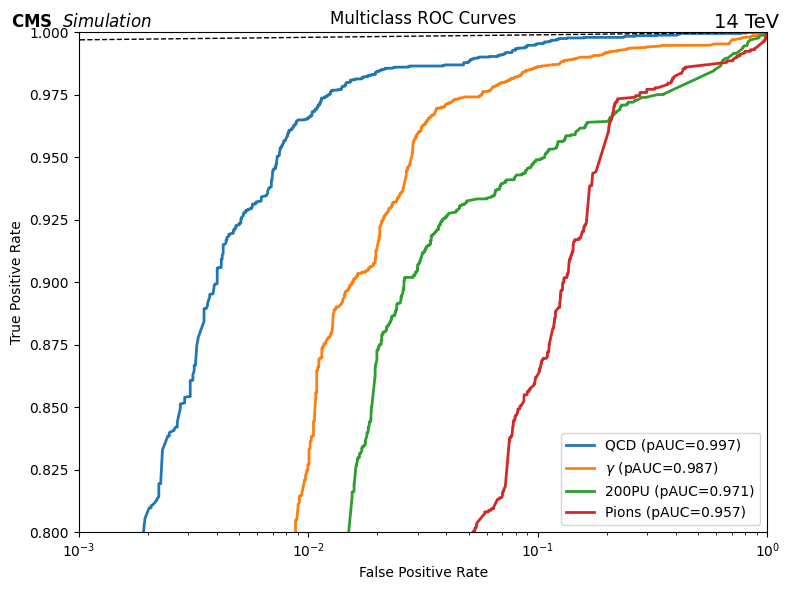

In [72]:
thr = 0.8  # signal efficiency threshold
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}
partial_auc = {}

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    # ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr_full, tpr_full)

    # Keep only points with TPR >= 0.8
    mask = tpr_full >= 0
    if np.sum(mask) > 1:
        fpr[i], tpr[i] = fpr_full[mask], tpr_full[mask]
        partial_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_names[i]} (pAUC={partial_auc[i]:.3f})")
    else:
        fpr[i], tpr[i] = None, None
        partial_auc[i] = np.nan

# Diagonal line (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.001, 1.0])
plt.ylim([thr, 1.0])  # zoom into TPR >= 0.8
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
fig = plt.gcf()
plt.subplots_adjust(top=0.98, right=0.95)
fig.text(0.02, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.98, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.tight_layout()
plt.savefig("newsamples_Ref_plots/multiclass_roc_ovr.pdf")
plt.show()

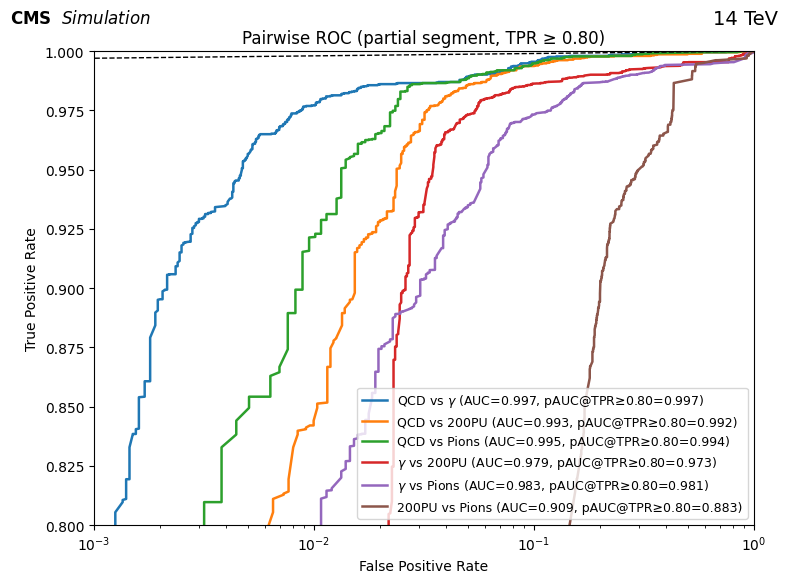

pos_class neg_class      AUC  pAUC_TPR>=0.8  n_samples  n_pos  n_neg
      QCD  $\gamma$ 0.997342       0.997006      24454   4451  20003
      QCD     Pions 0.994585       0.993748       6030   4451   1579
      QCD     200PU 0.993265       0.991623       7061   4451   2610
 $\gamma$     Pions 0.982909       0.980850      21582  20003   1579
 $\gamma$     200PU 0.978984       0.973360      22613  20003   2610
    200PU     Pions 0.908953       0.883364       4189   2610   1579
      QCD       QCD      NaN            NaN       4451   4451   4451
 $\gamma$  $\gamma$      NaN            NaN      20003  20003  20003
    200PU     200PU      NaN            NaN       2610   2610   2610
    Pions     Pions      NaN            NaN       1579   1579   1579


In [73]:
classes = np.arange(y_pred_proba.shape[1])  # or: np.unique(y_test)
n_classes = len(classes)

results = []
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    for j in range(i, n_classes):
        # Keep only samples from classes i and j
        mask = (y_test == i) | (y_test == j)
        if not np.any(mask):
            continue

        y_true = (y_test[mask] == i).astype(int)       # i is positive class
        y_score = y_pred_proba[mask, i]               # score for class i

        # Need both classes present to compute ROC
        if len(np.unique(y_true)) < 2:
            full_auc = np.nan
            fpr_full, tpr_full = np.array([0, 1]), np.array([0, 1])
        else:
            fpr_full, tpr_full, _ = roc_curve(y_true, y_score)
            full_auc = auc(fpr_full, tpr_full)

        # Partial AUC for TPR >= thr
        keep = tpr_full >= 0.6
        if np.count_nonzero(keep) >= 2:
            fpr_p, tpr_p = fpr_full[keep], tpr_full[keep]
            p_auc = auc(fpr_p, tpr_p)

            # Plot only the partial segment to focus on high efficiency
            plt.plot(fpr_p, tpr_p, lw=1.8,
                     label=f"{class_names[i]} vs {class_names[j]} "
                           f"(AUC={full_auc:.3f}, pAUC@TPR≥{thr:.2f}={p_auc:.3f})")
        else:
            p_auc = np.nan

        results.append({
            "pos_class": class_names[i],
            "neg_class": class_names[j],
            "AUC": full_auc,
            f"pAUC_TPR>={thr}": p_auc,
            "n_samples": int(mask.sum()),
            "n_pos": int((y_test[mask] == i).sum()),
            "n_neg": int((y_test[mask] == j).sum()),
        })

# Chance diagonal (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([1e-3, 1.0])
plt.ylim([thr, 1.0])          # zoom into high-efficiency region
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pairwise ROC (partial segment, TPR ≥ {:.2f})'.format(thr))
plt.legend(loc='lower right', fontsize=9)
fig = plt.gcf()
plt.subplots_adjust(top=0.90, right=0.95)
fig.text(0.02, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.98, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_Ref_plots/multiclass_roc_ovo.pdf")
plt.show()

# Summary table
df_pairwise = pd.DataFrame(results)
print(df_pairwise.sort_values("AUC", ascending=False).to_string(index=False))


In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

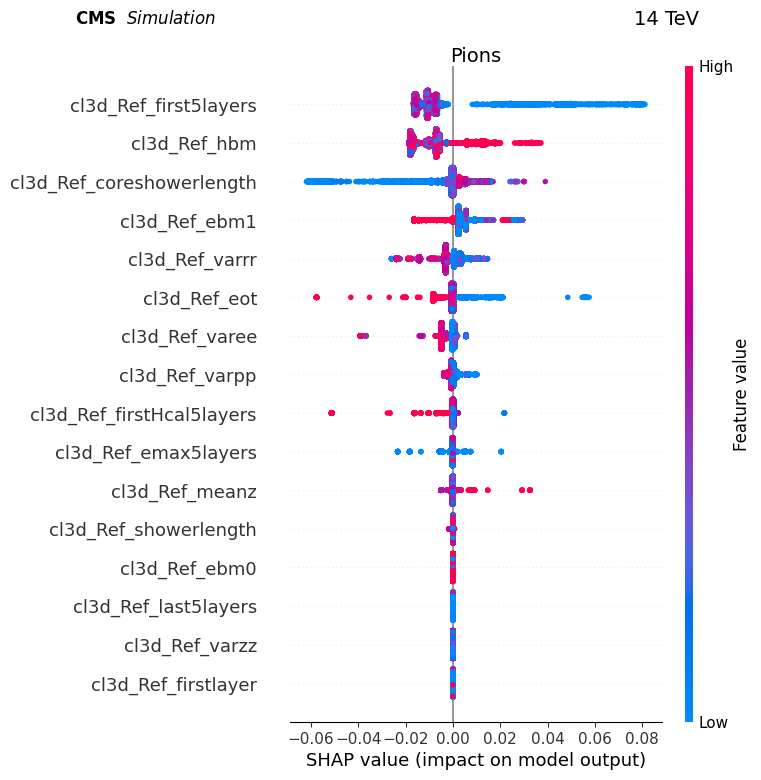

In [75]:
shap_vals_pion = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pion, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
plt.title("Pions", fontsize=14, pad=-10)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplots_adjust(top=0.90, right=0.95)
fig.text(0.1, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_Ref_plots/SHAP_pions.pdf", bbox_inches="tight")
plt.show()

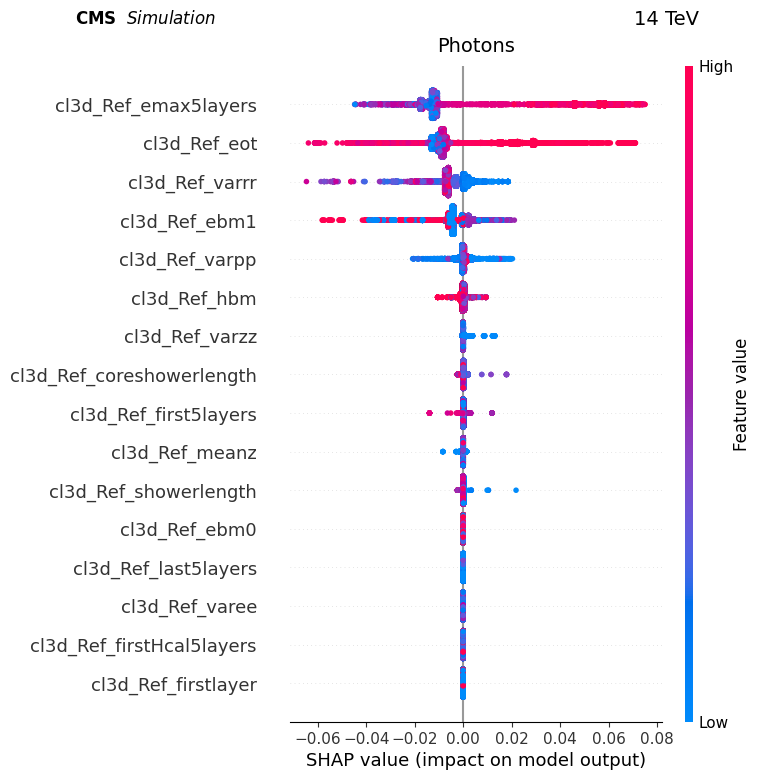

In [76]:
shap_vals_egamma = shap_values[:, :, 0]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
plt.title("Photons", fontsize=14, pad=10)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplots_adjust(top=0.90, right=0.95)
fig.text(0.1, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_Ref_plots/SHAP_photons.pdf", dpi = 300)
plt.show()

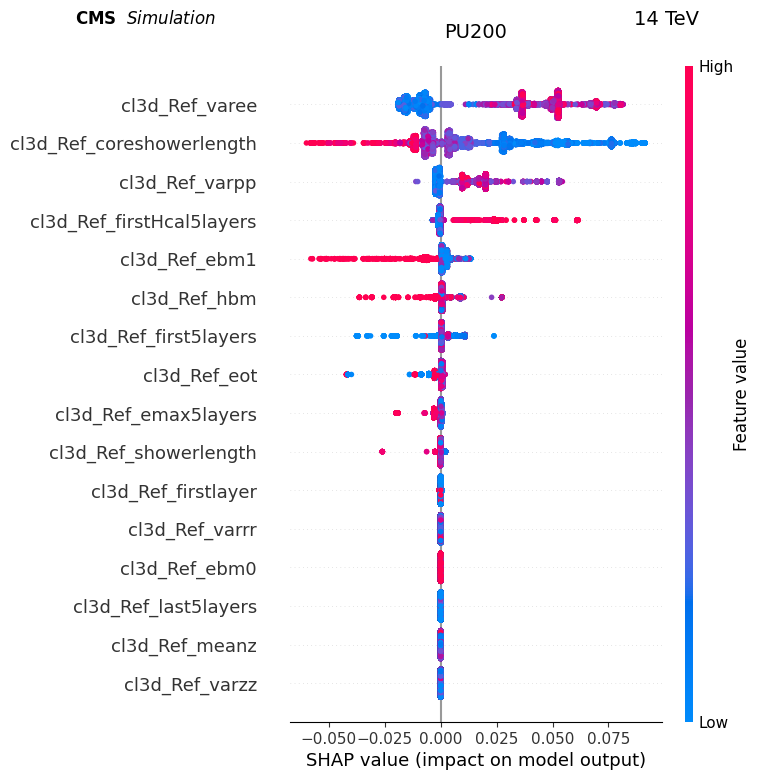

In [77]:
shap_vals_pu = shap_values[:, :, 1]
shap.summary_plot(shap_vals_pu, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
plt.title("PU200", fontsize=14, pad=20)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplots_adjust(top=0.90, right=0.95)
fig.text(0.10, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_Ref_plots/SHAP_PU200.pdf", dpi = 300)
plt.show()

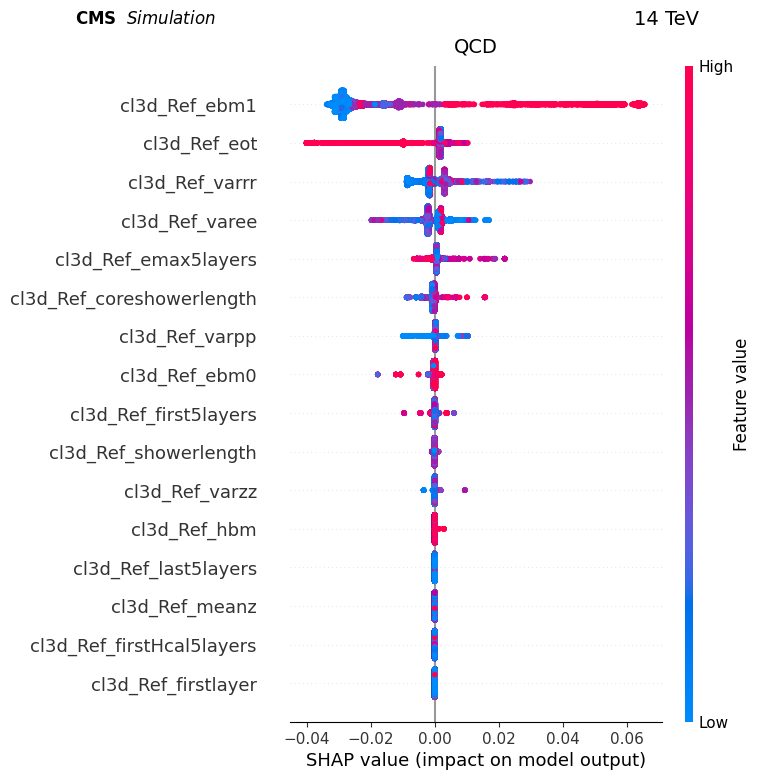

In [78]:
shap_vals_qcd = shap_values[:, :, 2]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
plt.title("QCD", fontsize=14, pad=10)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplots_adjust(top=0.90, right=0.95)
fig.text(0.10, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_Ref_plots/SHAP_qcd.pdf", dpi = 300)
plt.show()

## Understanding the difference of triangle sizes

## Let's make some plots!

Saved: plot_triangles_genmatched/pt_across_triangles.pdf


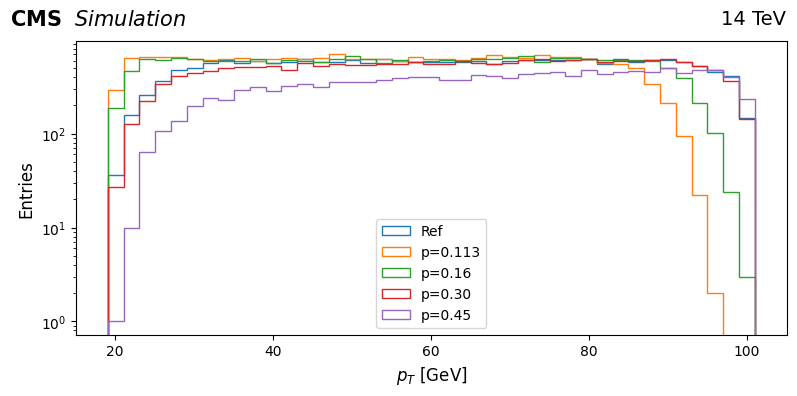

Saved: plot_triangles_genmatched/energy_across_triangles.pdf


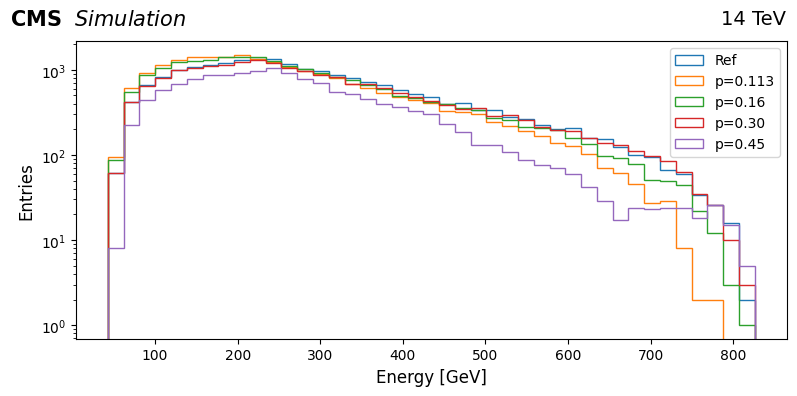

Saved: plot_triangles_genmatched/eta_across_triangles.pdf


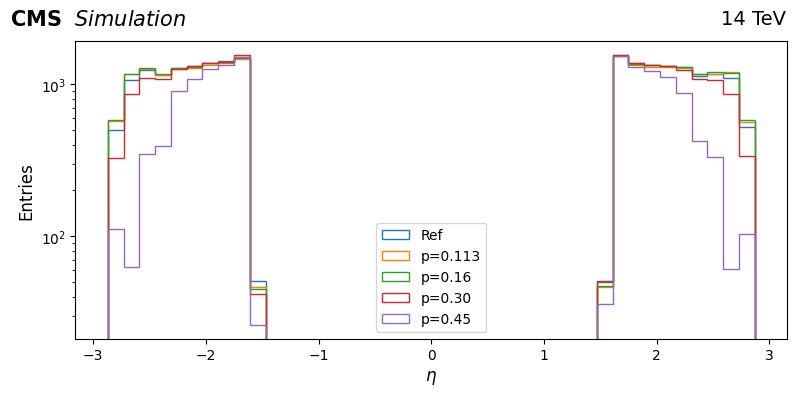

Saved: plot_triangles_genmatched/phi_across_triangles.pdf


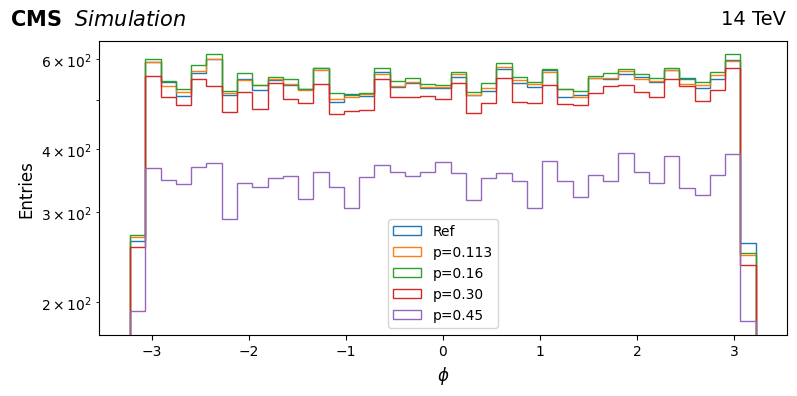

Saved: plot_triangles_genmatched/emax1layers_across_triangles.pdf


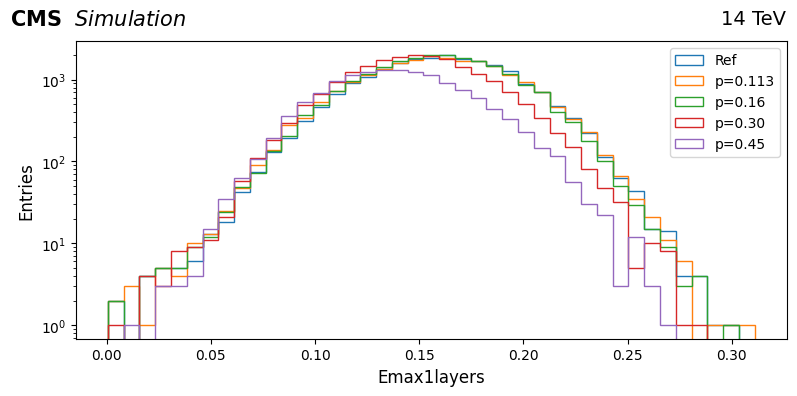

Saved: plot_triangles_genmatched/emax3layers_across_triangles.pdf


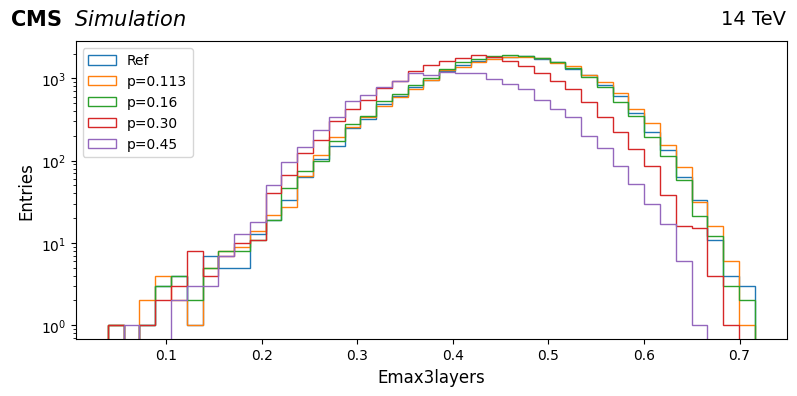

Saved: plot_triangles_genmatched/showerlength_across_triangles.pdf


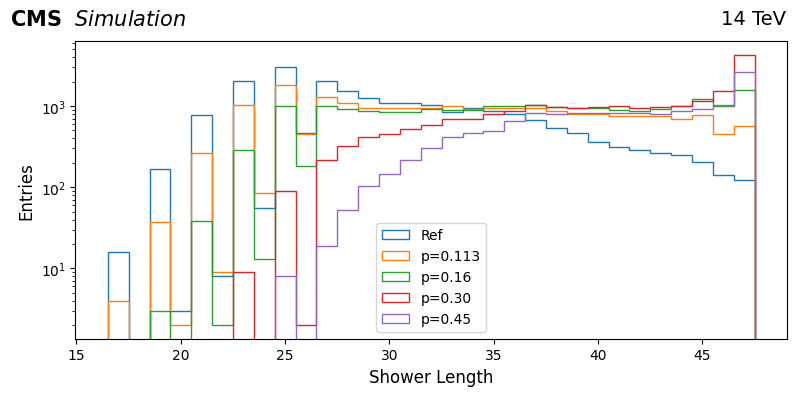

Saved: plot_triangles_genmatched/coreshowerlength_across_triangles.pdf


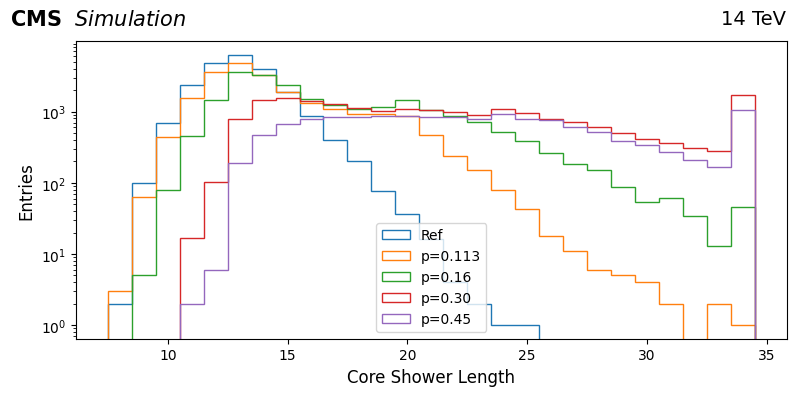

Saved: plot_triangles_genmatched/firstlayer_across_triangles.pdf


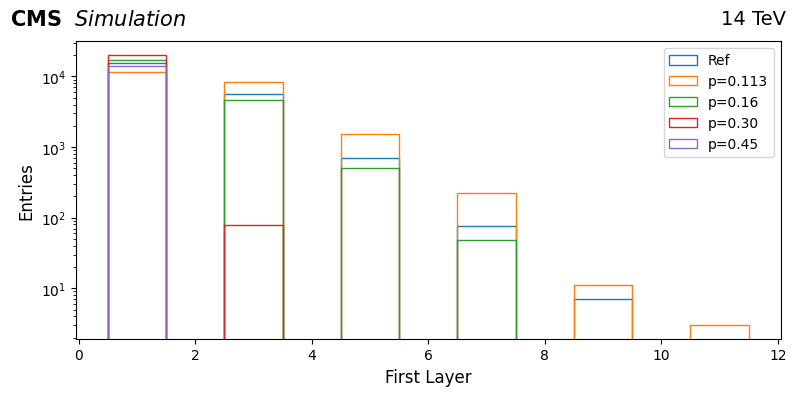

Saved: plot_triangles_genmatched/maxlayer_across_triangles.pdf


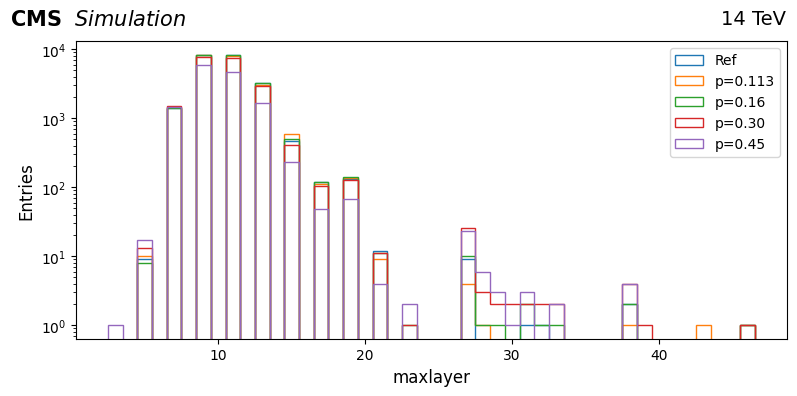

Saved: plot_triangles_genmatched/varrr_across_triangles.pdf


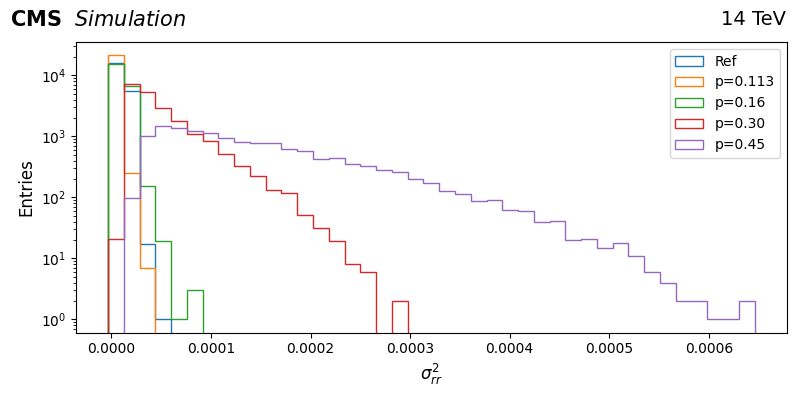

Saved: plot_triangles_genmatched/varzz_across_triangles.pdf


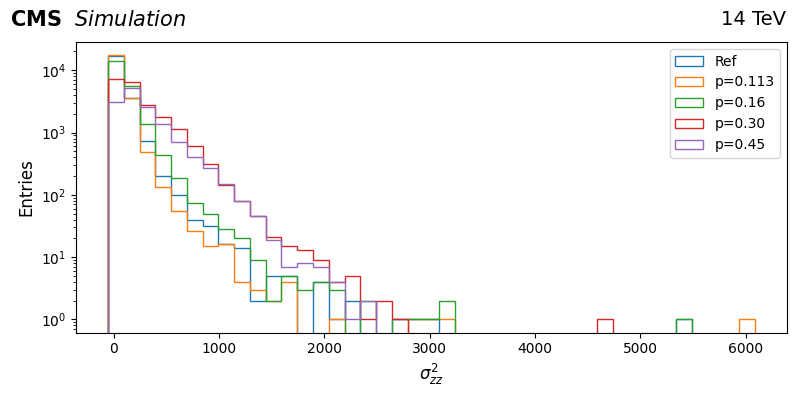

Saved: plot_triangles_genmatched/varee_across_triangles.pdf


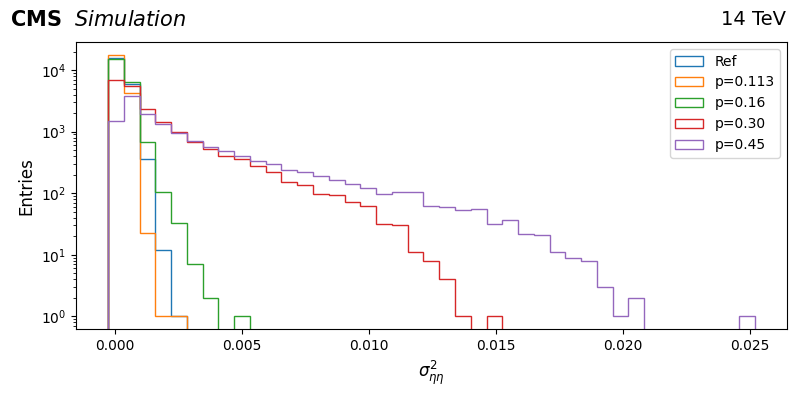

Saved: plot_triangles_genmatched/varpp_across_triangles.pdf


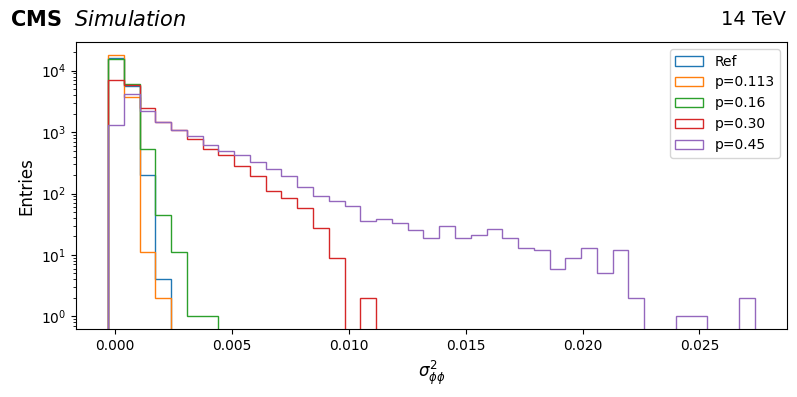

Saved: plot_triangles_genmatched/emaxe_across_triangles.pdf


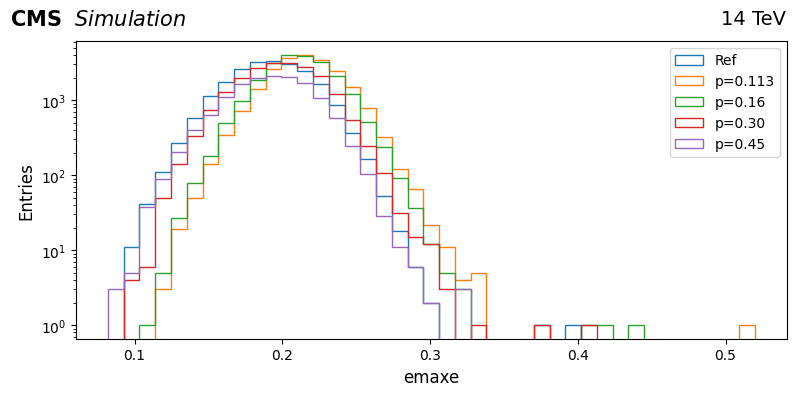

Saved: plot_triangles_genmatched/hoe_across_triangles.pdf


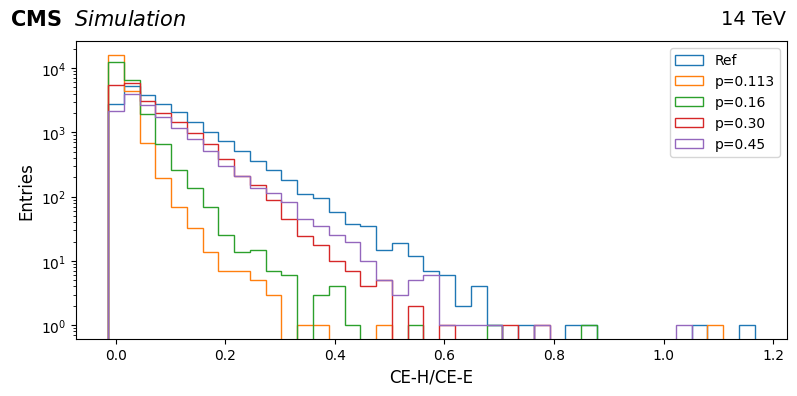

Saved: plot_triangles_genmatched/meanz_across_triangles.pdf


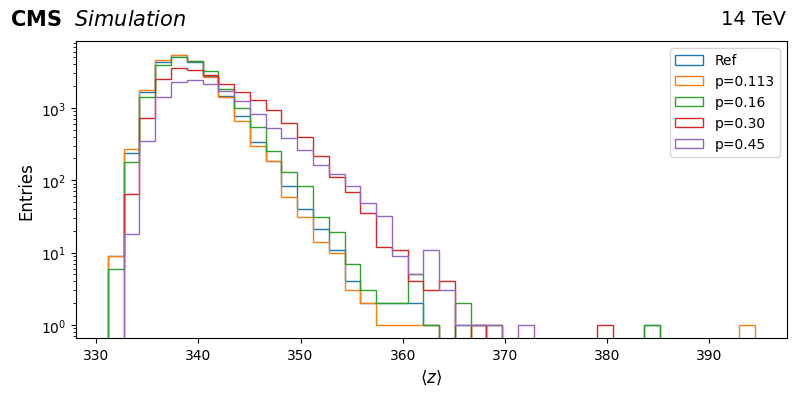

Saved: plot_triangles_genmatched/first1layers_across_triangles.pdf


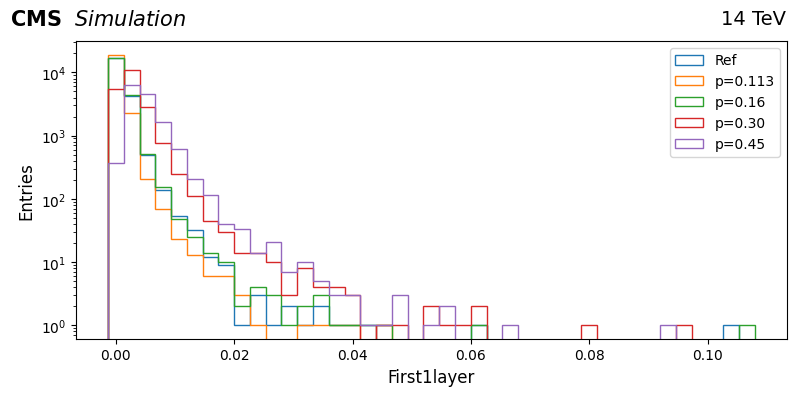

Saved: plot_triangles_genmatched/first3layers_across_triangles.pdf


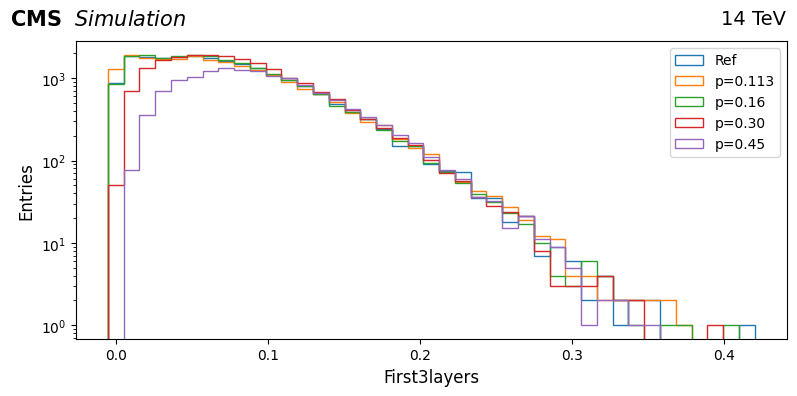

Saved: plot_triangles_genmatched/first5layers_across_triangles.pdf


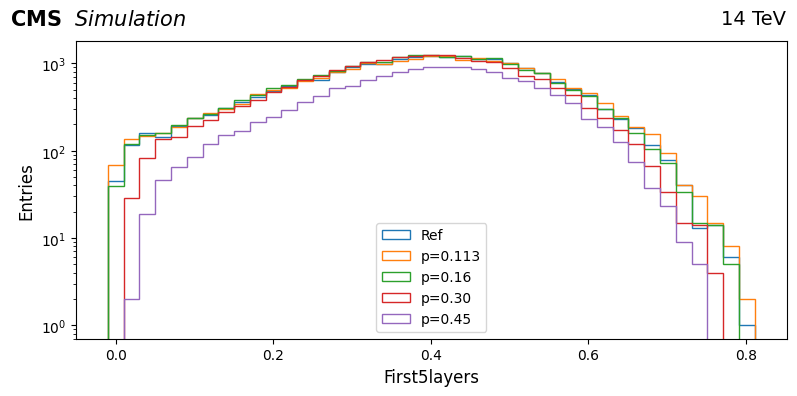

Saved: plot_triangles_genmatched/firstHcal1layers_across_triangles.pdf


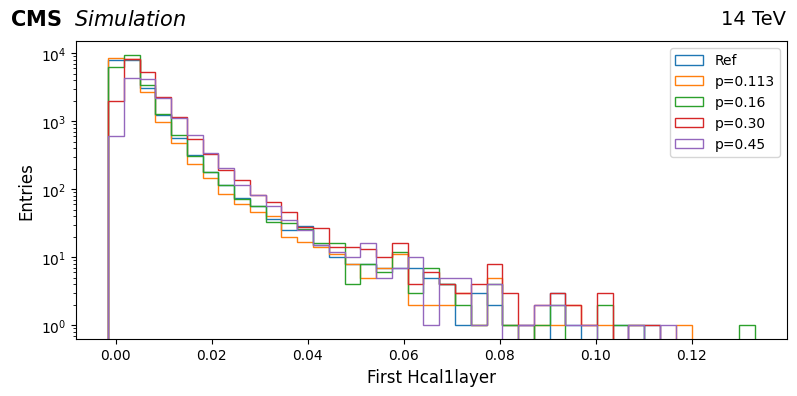

Saved: plot_triangles_genmatched/firstHcal3layers_across_triangles.pdf


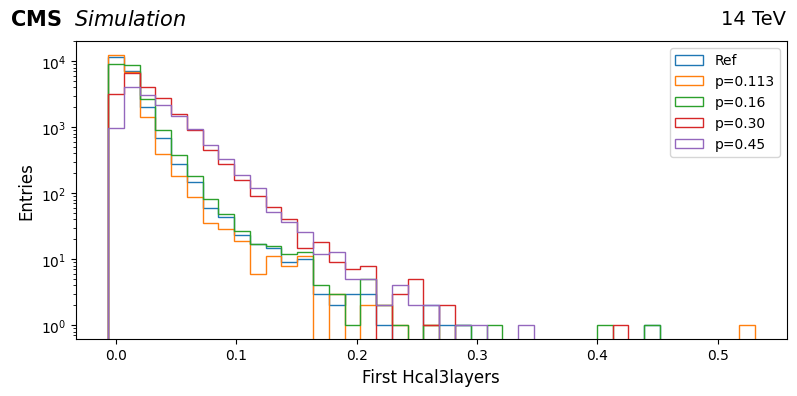

Saved: plot_triangles_genmatched/firstHcal5layers_across_triangles.pdf


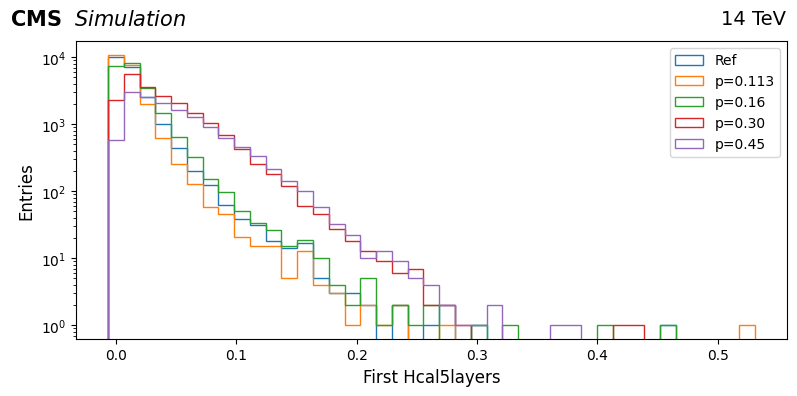

Saved: plot_triangles_genmatched/last1layers_across_triangles.pdf


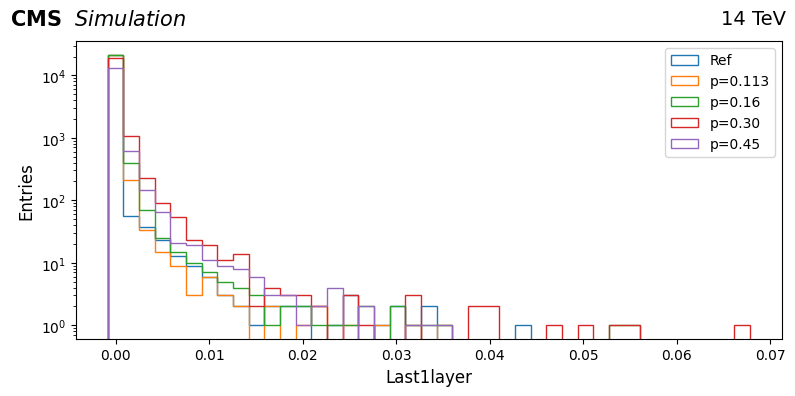

Saved: plot_triangles_genmatched/last3layers_across_triangles.pdf


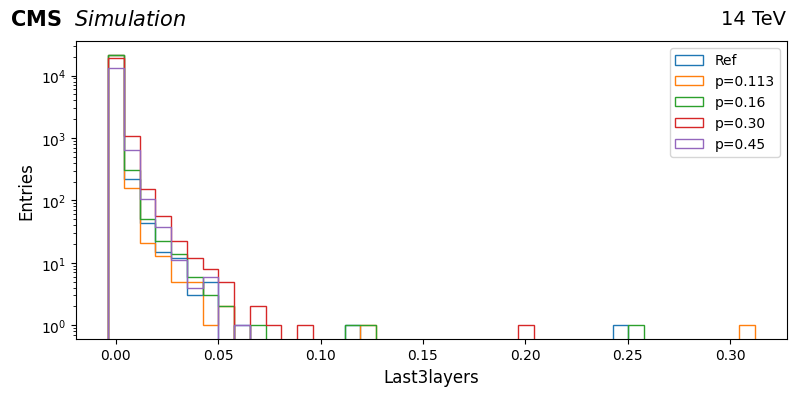

Saved: plot_triangles_genmatched/last5layers_across_triangles.pdf


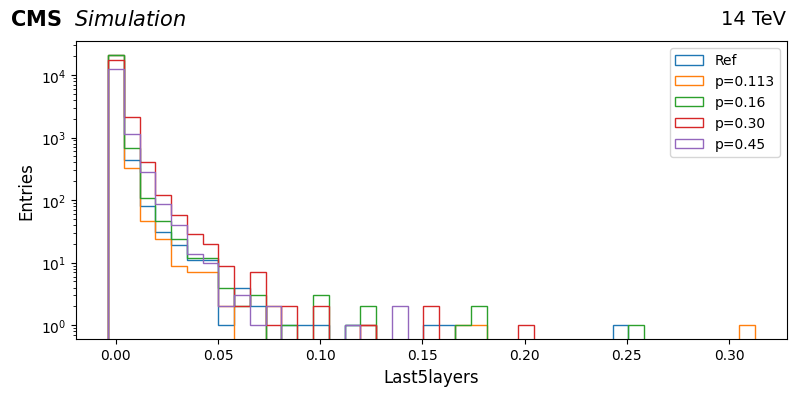

Saved: plot_triangles_genmatched/eot_across_triangles.pdf


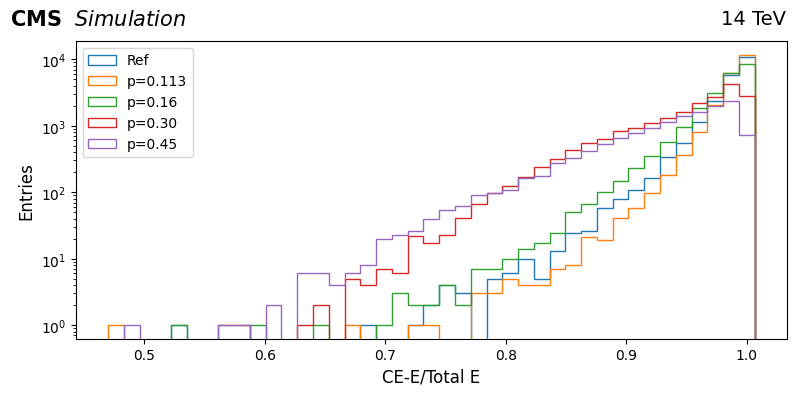

Saved: plot_triangles_genmatched/ebm0_across_triangles.pdf


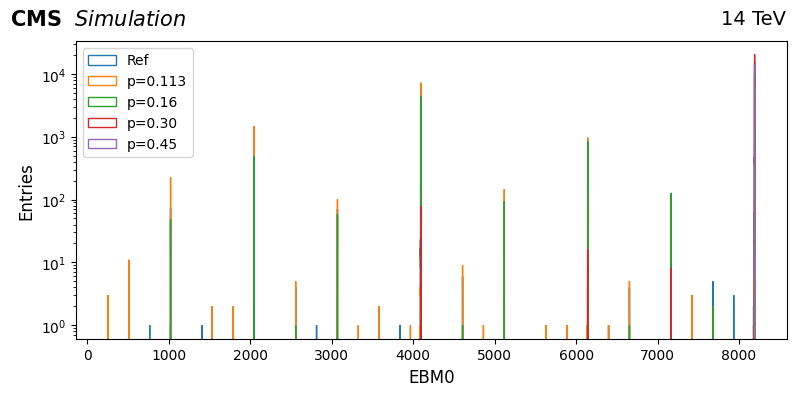

Saved: plot_triangles_genmatched/ebm1_across_triangles.pdf


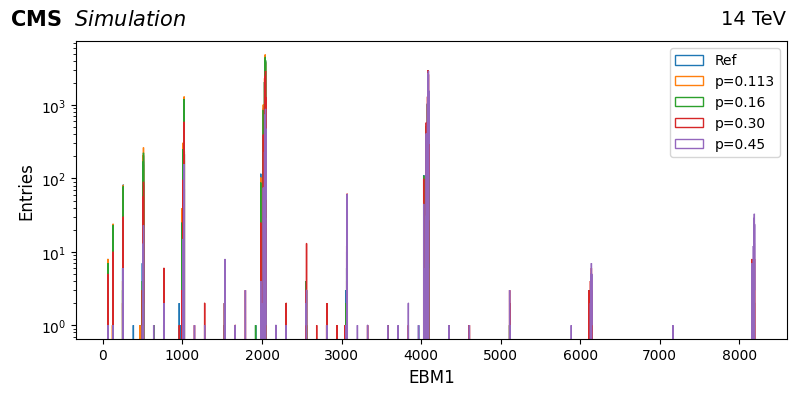

In [60]:
ana.plot_across_five_lists(
    photon_df_Ref_filtered, photon_df_p0113_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p0113Tri'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plot_triangles_genmatched",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 100),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [79]:
def plot_histograms(df_signal, df_bg1, df_bg2, df_bg3, variables, label_signal, label_bg1, label_bg2, label_bg3, plots_dir, var_latex_map, prefix, num_bins=40, cl3d_pt_range=(20, 100), figsize=(8, 4)):
    df_signal_filtered = df_signal[(df_signal[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_signal[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg1_filtered = df_bg1[(df_bg1[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg1[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg2_filtered = df_bg2[(df_bg2[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg2[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg3_filtered = df_bg3[(df_bg3[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg3[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_signal_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(df_signal_filtered[var].min(), df_bg1_filtered[var].min(), df_bg2_filtered[var].min(), df_bg3_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg1_filtered[var].max(), df_bg2_filtered[var].max(), df_bg3_filtered[var].max())
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(df_signal_filtered[var].min(), df_bg1_filtered[var].min(), df_bg2_filtered[var].min(), df_bg3_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg1_filtered[var].max(), df_bg2_filtered[var].max(), df_bg3_filtered[var].max())
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        plt.hist(df_signal_filtered[var], histtype='step', bins=bin_edges, color='b', linewidth=1.5, label=label_signal, density=True)
        plt.hist(df_bg1_filtered[var], histtype='step', bins=bin_edges, color='g', linewidth=1.5, label=label_bg1, density=True)
        plt.hist(df_bg2_filtered[var], histtype='step', bins=bin_edges, color='r', linewidth=1.5, label=label_bg2, density=True)
        plt.hist(df_bg3_filtered[var], histtype='step', bins=bin_edges, color='black', linewidth=1.5, label=label_bg3, density=True)
        plt.title("Cluster " + f"{var_latex_map.get(var, var)} Histogram", fontsize=14)
        plt.xlabel(var_latex_map.get(var, var), fontsize=12)
        plt.ylabel('Normalized Frequency', fontsize=12)
        plt.legend()
        plt.tight_layout()
        fig = plt.gcf()
        fig.text(0.01, 0.98, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=15)
        fig.text(0.98, 0.98, "14 TeV",                 ha="right", va="top", fontsize=14)
        plt.subplots_adjust(top=0.90)
        filename = os.path.join(plots_dir, f"{var}_histogram.pdf")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

Saved: newsamples_Ref_plots/cl3d_Ref_pt_histogram.pdf


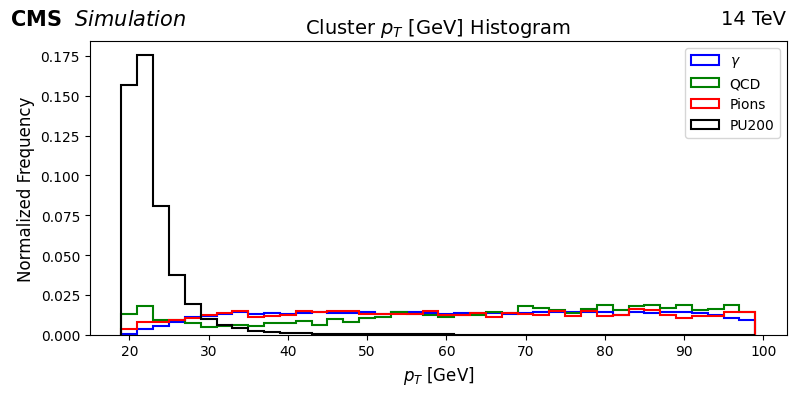

Saved: newsamples_Ref_plots/cl3d_Ref_energy_histogram.pdf


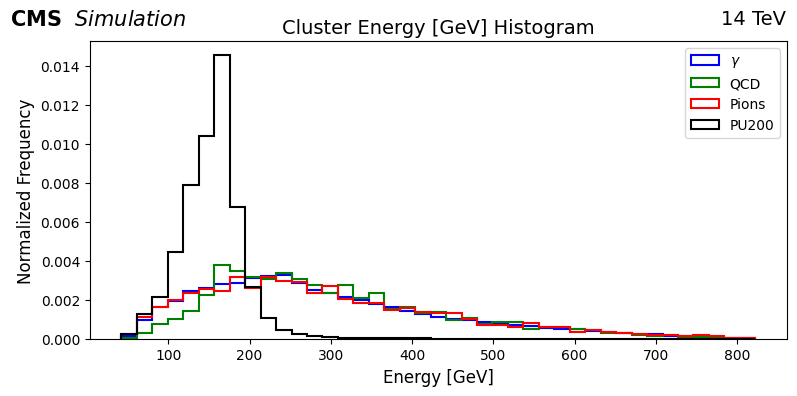

Saved: newsamples_Ref_plots/cl3d_Ref_eta_histogram.pdf


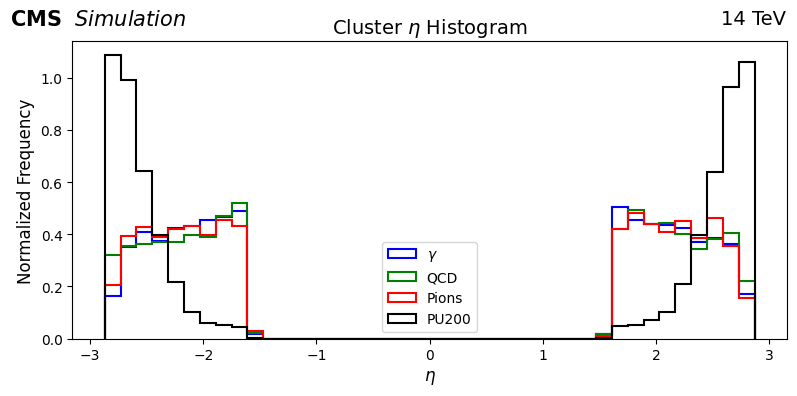

Saved: newsamples_Ref_plots/cl3d_Ref_phi_histogram.pdf


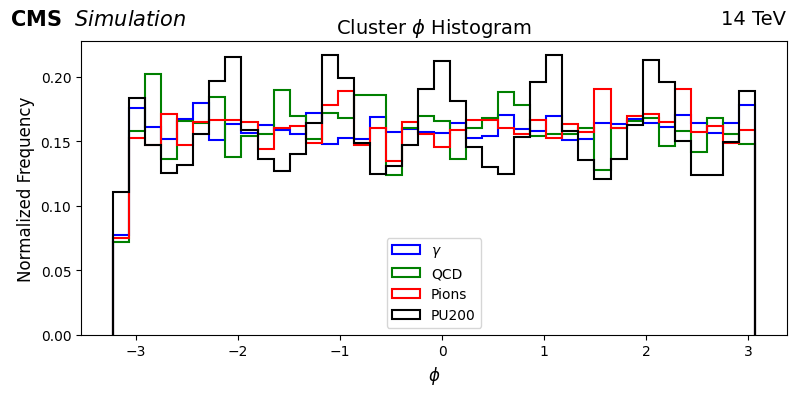

Saved: newsamples_Ref_plots/cl3d_Ref_emax1layers_histogram.pdf


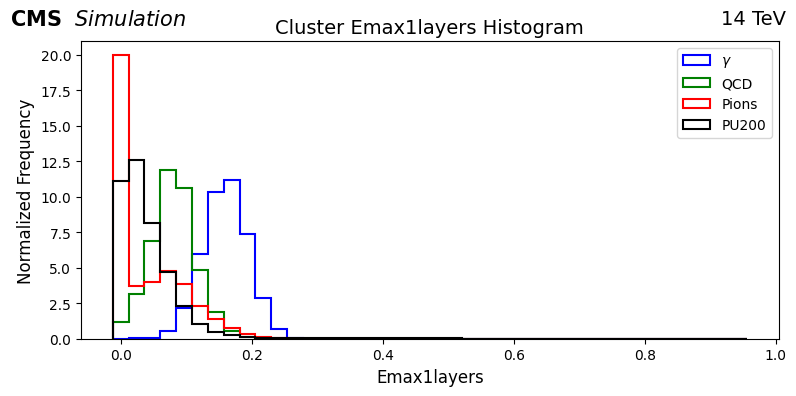

Saved: newsamples_Ref_plots/cl3d_Ref_emax3layers_histogram.pdf


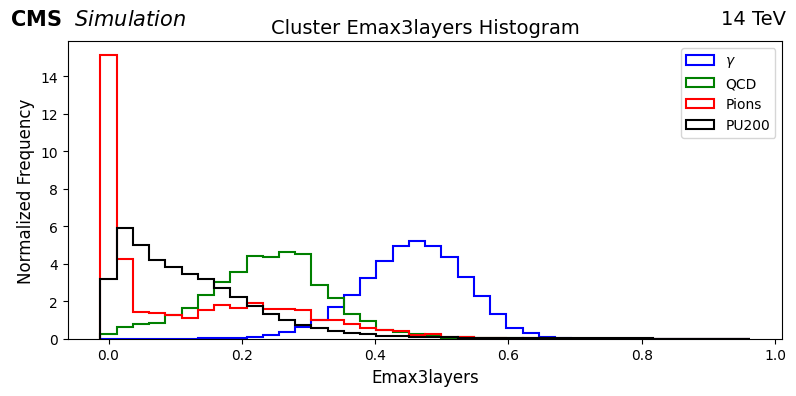

Saved: newsamples_Ref_plots/cl3d_Ref_showerlength_histogram.pdf


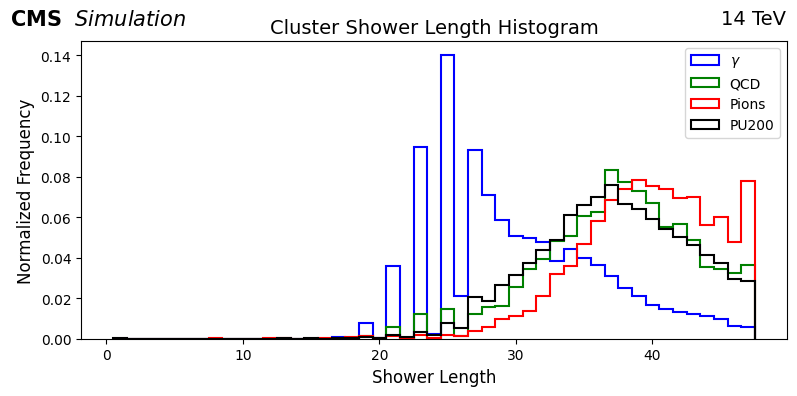

Saved: newsamples_Ref_plots/cl3d_Ref_coreshowerlength_histogram.pdf


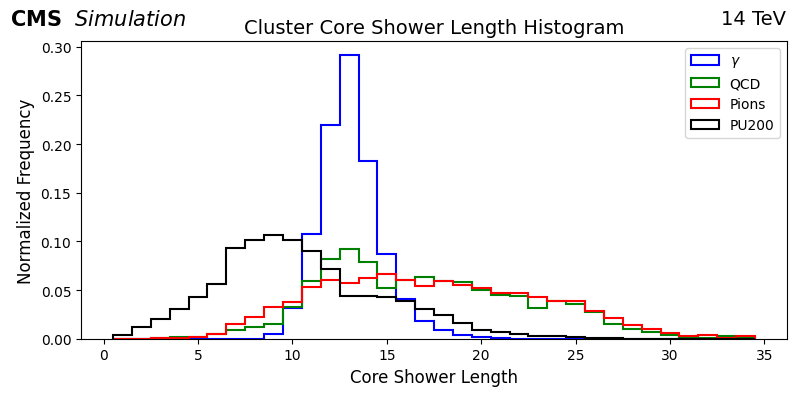

Saved: newsamples_Ref_plots/cl3d_Ref_firstlayer_histogram.pdf


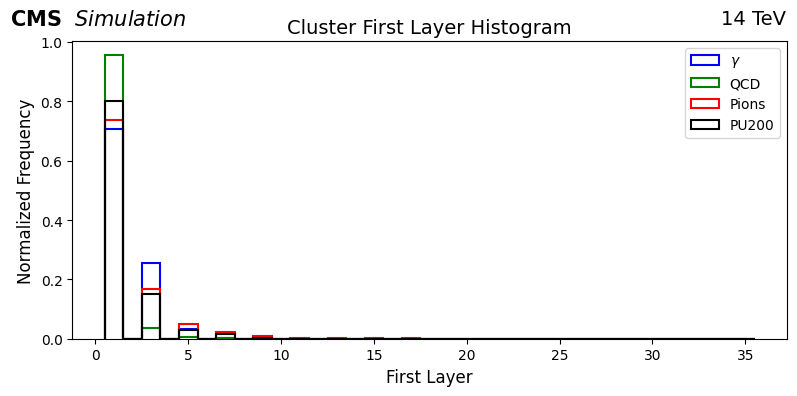

Saved: newsamples_Ref_plots/cl3d_Ref_maxlayer_histogram.pdf


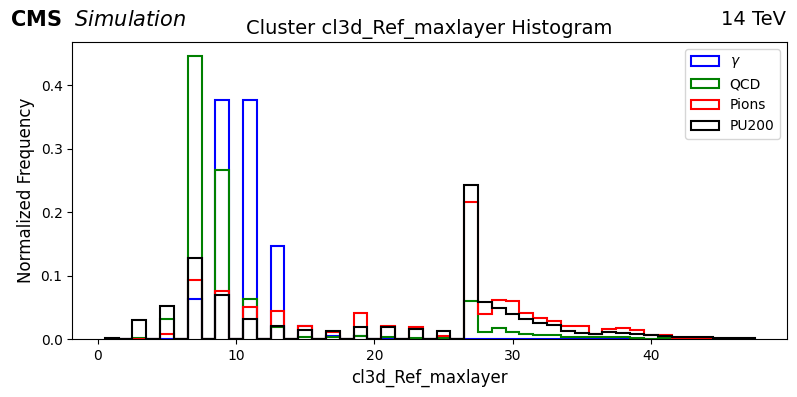

Saved: newsamples_Ref_plots/cl3d_Ref_varrr_histogram.pdf


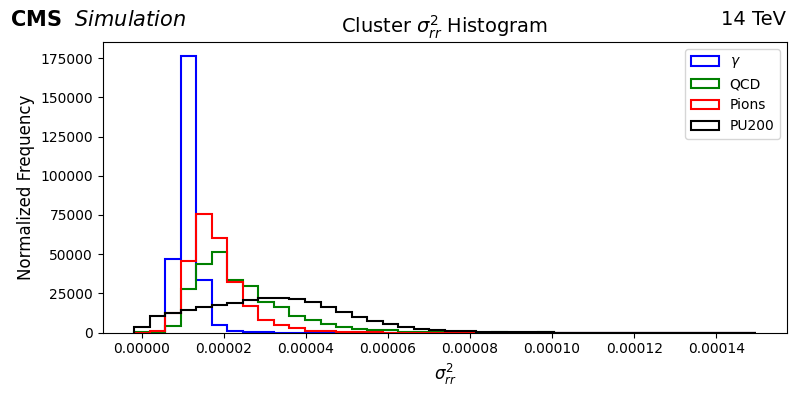

Saved: newsamples_Ref_plots/cl3d_Ref_varzz_histogram.pdf


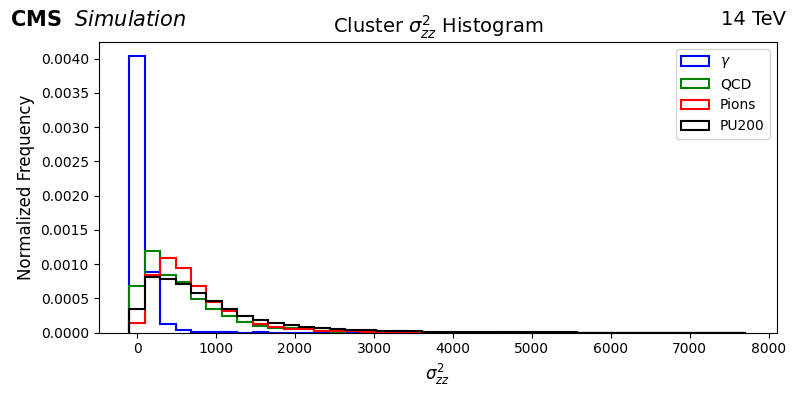

Saved: newsamples_Ref_plots/cl3d_Ref_varee_histogram.pdf


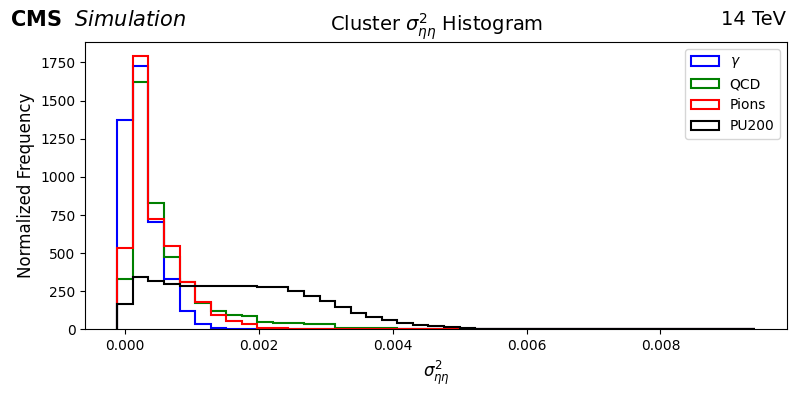

Saved: newsamples_Ref_plots/cl3d_Ref_varpp_histogram.pdf


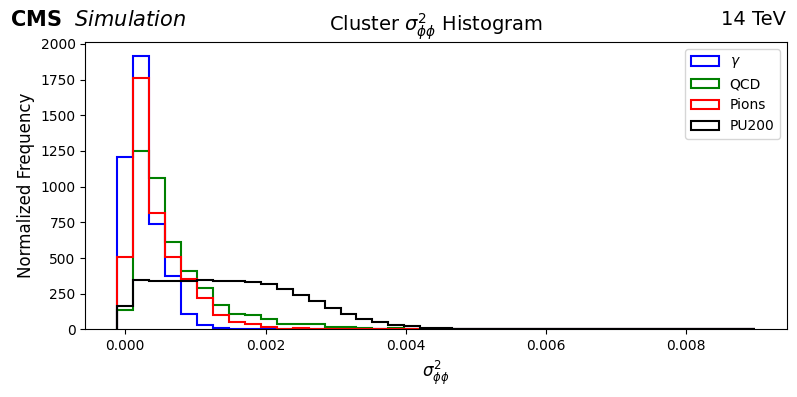

Saved: newsamples_Ref_plots/cl3d_Ref_emaxe_histogram.pdf


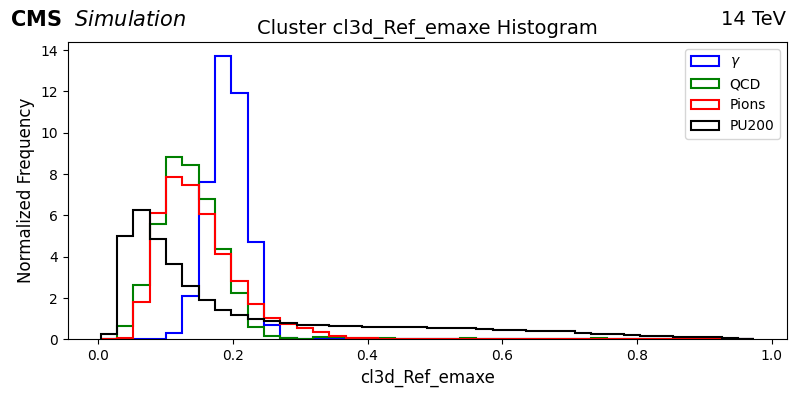

Saved: newsamples_Ref_plots/cl3d_Ref_hoe_histogram.pdf


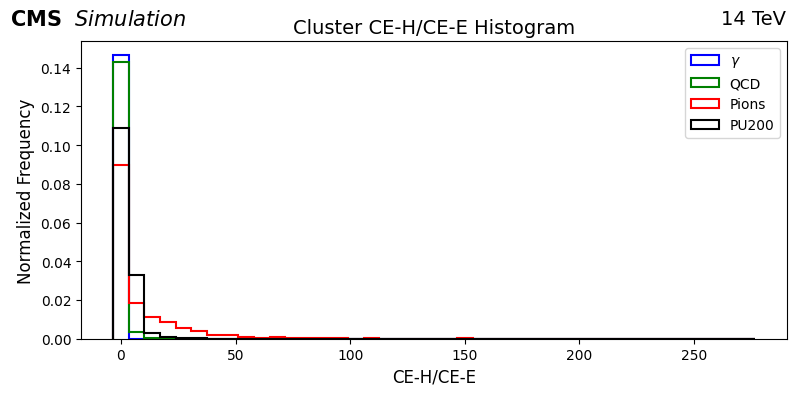

Saved: newsamples_Ref_plots/cl3d_Ref_meanz_histogram.pdf


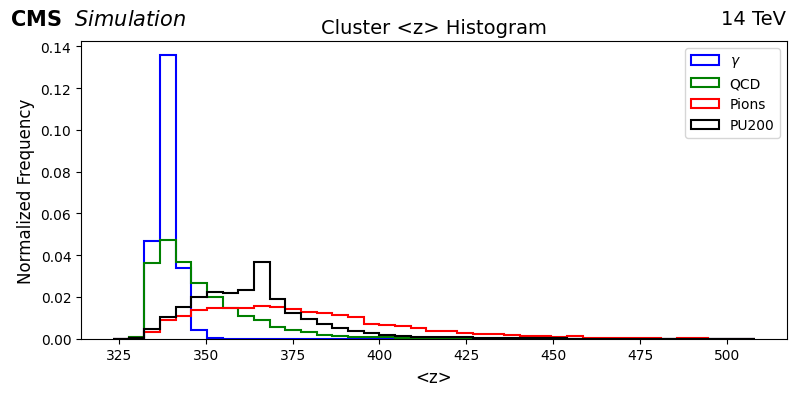

Saved: newsamples_Ref_plots/cl3d_Ref_first1layers_histogram.pdf


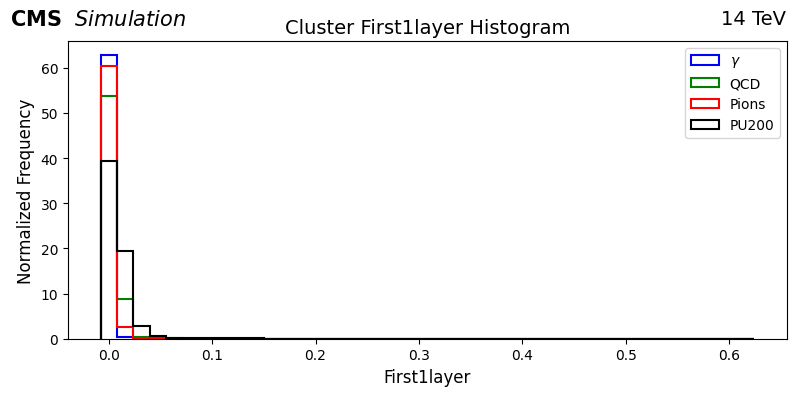

Saved: newsamples_Ref_plots/cl3d_Ref_first3layers_histogram.pdf


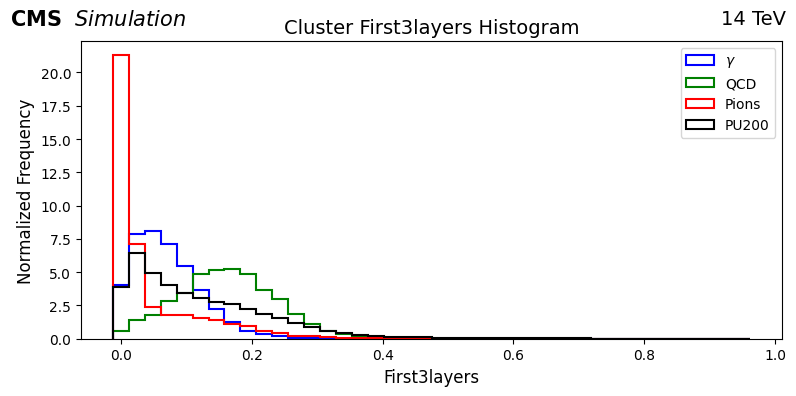

Saved: newsamples_Ref_plots/cl3d_Ref_first5layers_histogram.pdf


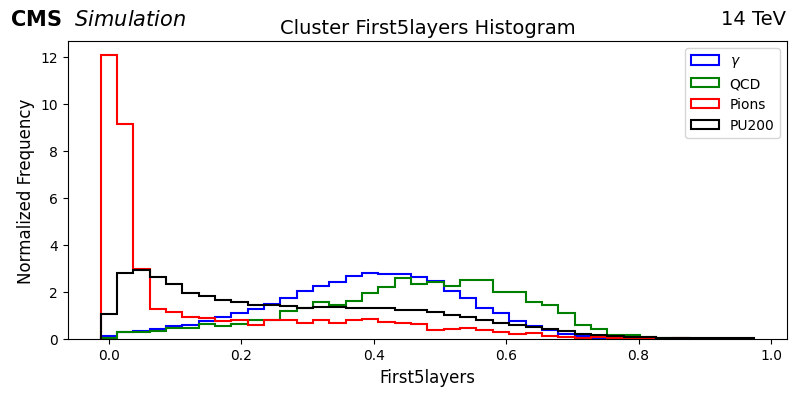

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal1layers_histogram.pdf


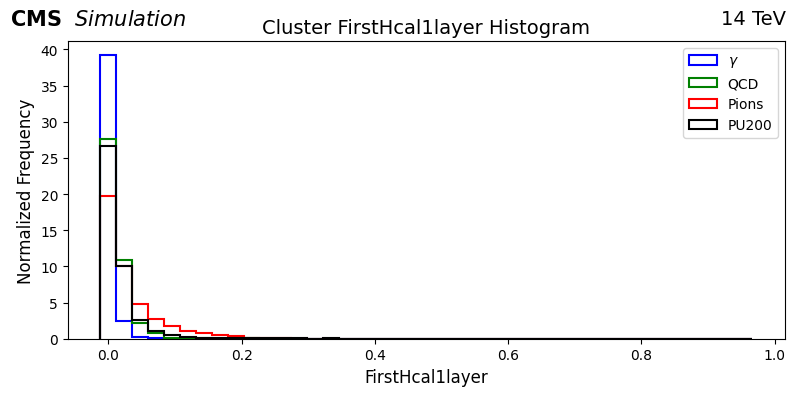

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal3layers_histogram.pdf


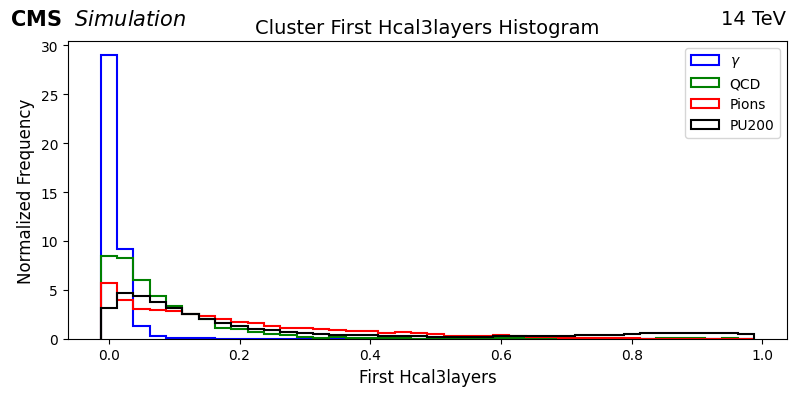

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal5layers_histogram.pdf


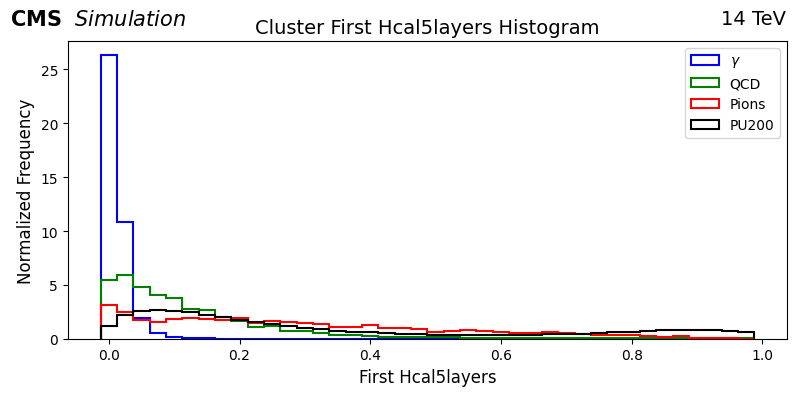

Saved: newsamples_Ref_plots/cl3d_Ref_last1layers_histogram.pdf


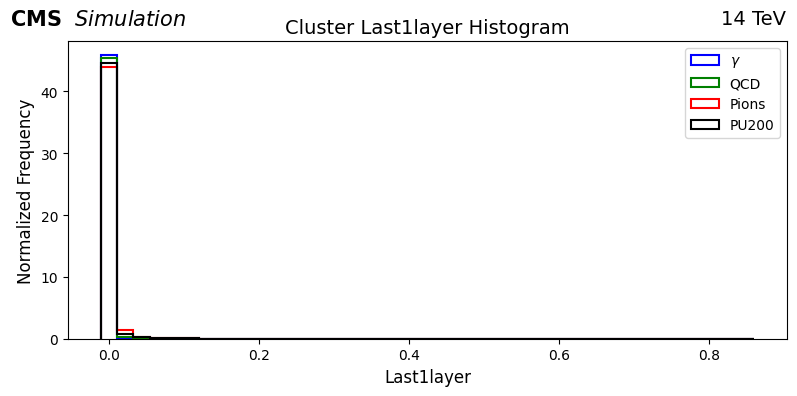

Saved: newsamples_Ref_plots/cl3d_Ref_last3layers_histogram.pdf


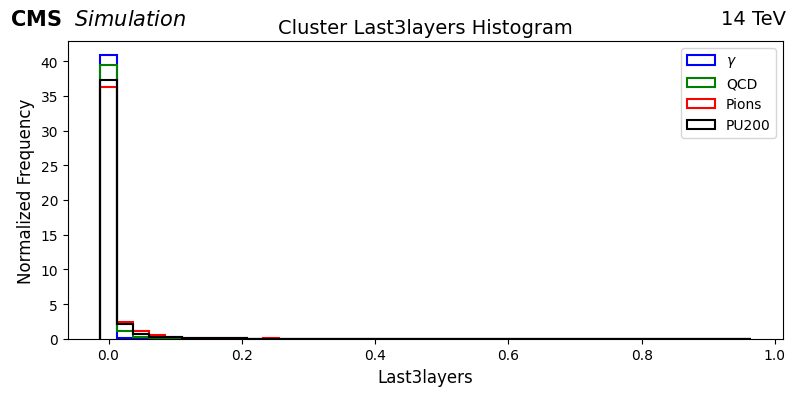

Saved: newsamples_Ref_plots/cl3d_Ref_last5layers_histogram.pdf


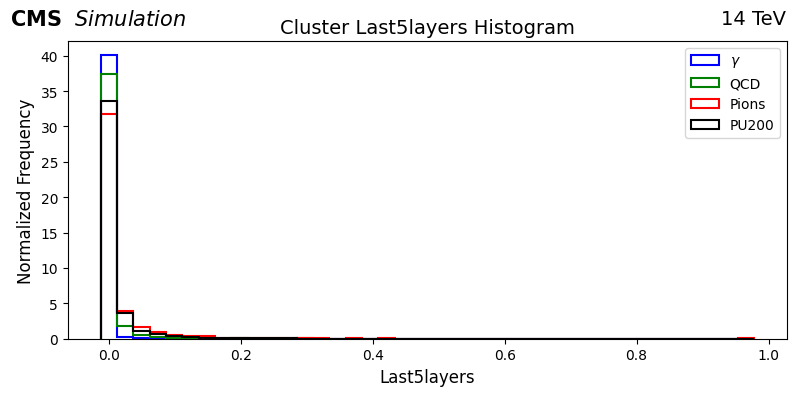

Saved: newsamples_Ref_plots/cl3d_Ref_eot_histogram.pdf


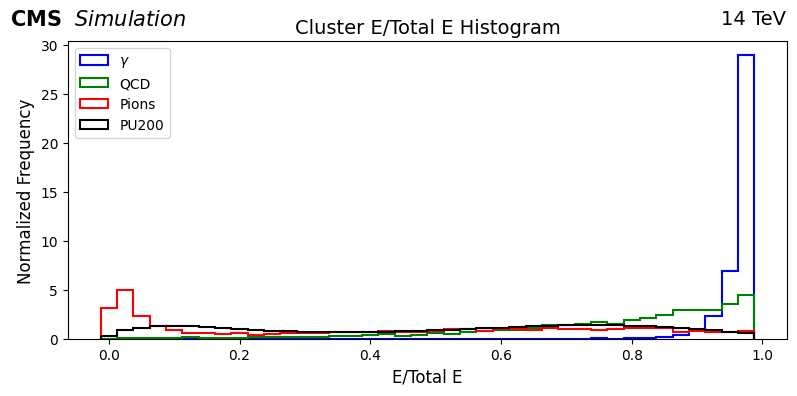

Saved: newsamples_Ref_plots/cl3d_Ref_ebm0_histogram.pdf


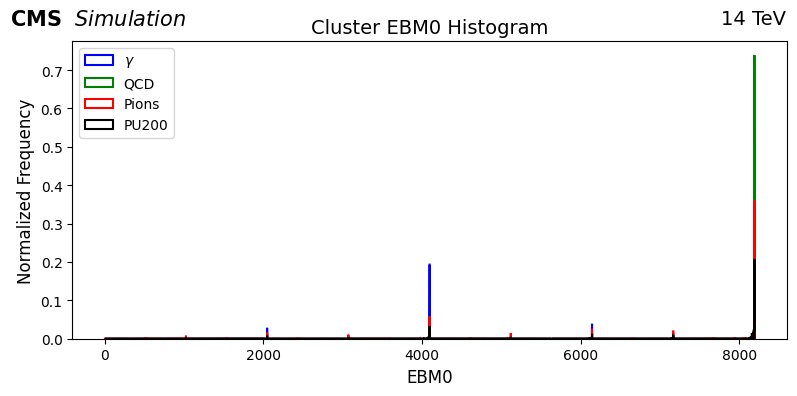

Saved: newsamples_Ref_plots/cl3d_Ref_ebm1_histogram.pdf


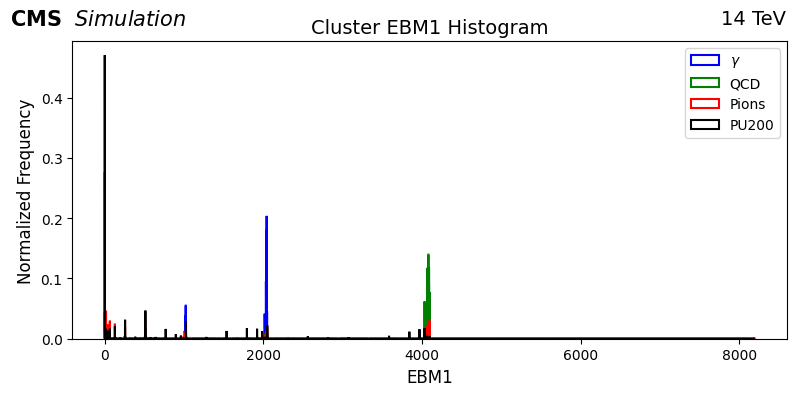

In [80]:
plot_histograms(photon_df_Ref_filtered, qcd_df_Ref_filtered, pion_df_Ref_filtered, PU_df_Ref, ana.variables_to_plot('Ref'), r'$\gamma$', 'QCD', 'Pions', 'PU200', 'newsamples_Ref_plots', ana.var_map('Ref'), 'Ref')

In [53]:
from typing import Optional, Tuple

def plot_eta_phi_pt(df,
                    eta_col: str,
                    phi_col: str,
                    pt_col: str,
                    mode: str = "scatter",                 # "scatter" or "meanpt"
                    bins_eta: int = 60,
                    bins_phi: int = 72,
                    eta_range: Optional[Tuple[float, float]] = None,  # e.g. (1.6, 2.8)
                    phi_range: Tuple[float, float] = (-np.pi, np.pi),
                    pt_range: Optional[Tuple[float, float]] = None,   # for color scaling
                    alpha: float = 0.7,
                    s: float = 6.0,
                    add_cms_header: bool = True,
                    left_status: str = "Simulation",
                    lumi_text: Optional[str] = None,
                    year_text: Optional[str] = None,
                    energy_text: str = "14 TeV",
                    outfile: Optional[str] = None):
    """η–φ plot with pT color coding. Python 3.9-compatible annotations."""
    eta = df[eta_col].to_numpy()
    phi = df[phi_col].to_numpy()
    pt  = df[pt_col].to_numpy()
    m = np.isfinite(eta) & np.isfinite(phi) & np.isfinite(pt)

    if eta_range is not None:
        m &= (eta >= eta_range[0]) & (eta <= eta_range[1])
    if phi_range is not None:
        m &= (phi >= phi_range[0]) & (phi <= phi_range[1])

    eta, phi, pt = eta[m], phi[m], pt[m]

    fig, ax = plt.subplots(figsize=(7.0, 5.0))

    if mode.lower() == "scatter":
        sc = ax.scatter(eta, phi, c=pt, s=s, alpha=alpha,
                        vmin=(pt_range[0] if pt_range else None),
                        vmax=(pt_range[1] if pt_range else None))
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label(r" Cluster $p_T$ [GeV]")

    elif mode.lower() == "meanpt":
        # average pT per bin
        H_sum, eta_edges, phi_edges = np.histogram2d(
            eta, phi, bins=[bins_eta, bins_phi],
            range=[eta_range if eta_range else (float(np.min(eta)), float(np.max(eta))), phi_range],
            weights=pt
        )
        H_cnt, _, _ = np.histogram2d(
            eta, phi, bins=[bins_eta, bins_phi],
            range=[eta_range if eta_range else (float(np.min(eta)), float(np.max(eta))), phi_range]
        )
        with np.errstate(invalid="ignore", divide="ignore"):
            H_mean = H_sum / H_cnt
        X, Y = np.meshgrid(eta_edges, phi_edges, indexing="ij")
        im = ax.pcolormesh(X, Y, H_mean, shading="auto",
                           vmin=(pt_range[0] if pt_range else np.nanmin(H_mean)),
                           vmax=(pt_range[1] if pt_range else np.nanmax(H_mean)))
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(r" Cluster $p_T$ [GeV]")
    else:
        raise ValueError("mode must be 'scatter' or 'meanpt'")

    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    ax.set_ylim(phi_range)
    if eta_range is not None:
        ax.set_xlim(eta_range)
    fig.tight_layout()
    fig = plt.gcf()
    fig.text(0.01, 0.98, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=15)
    fig.text(0.98, 0.98, "14 TeV",                 ha="right", va="top", fontsize=14)
    plt.subplots_adjust(top=0.90)
    if outfile:
        fig.savefig(outfile, dpi=300)
    plt.show()
    plt.close(fig)


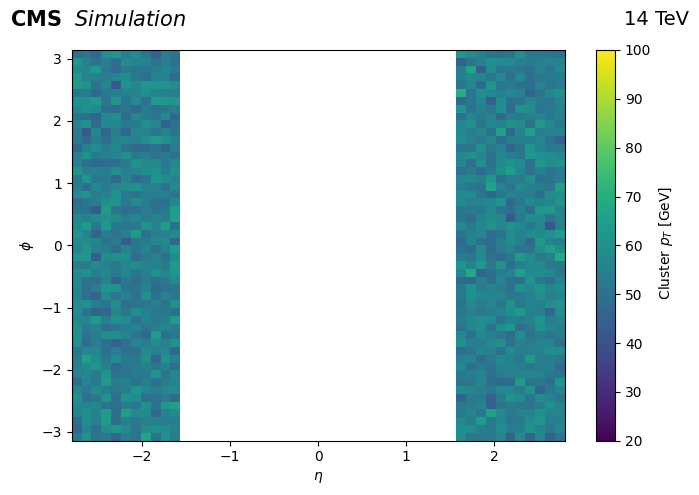

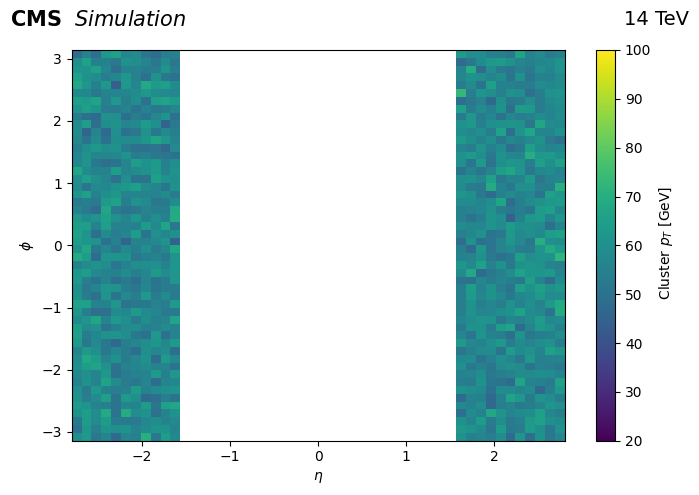

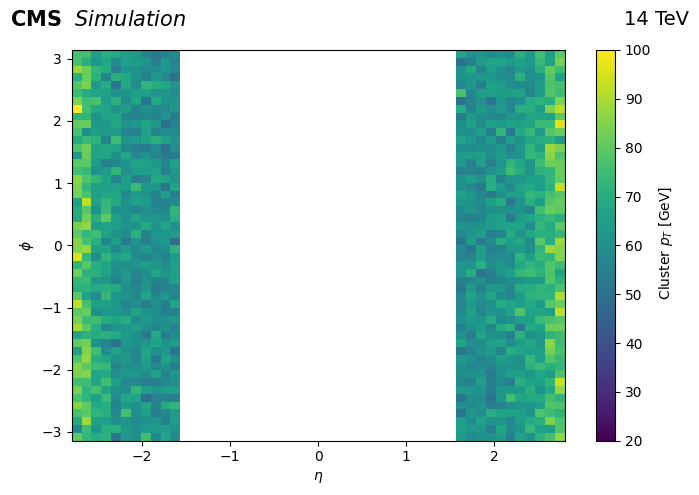

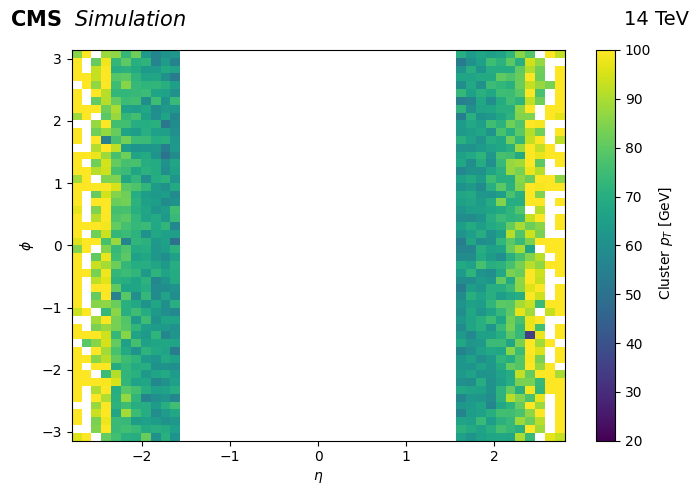

In [54]:
plot_eta_phi_pt(
    df=photon_df_p0113_filtered,
    eta_col="cl3d_p0113Tri_eta",
    phi_col="cl3d_p0113Tri_phi",
    pt_col="cl3d_p0113Tri_pt",
    mode="meanpt",
    bins_eta=50,
    bins_phi=50,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_meanpt_p0113.pdf"
)

plot_eta_phi_pt(
    df=photon_df_p016_filtered,
    eta_col="cl3d_p016Tri_eta",
    phi_col="cl3d_p016Tri_phi",
    pt_col="cl3d_p016Tri_pt",
    mode="meanpt",
    bins_eta=50,
    bins_phi=50,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_scatter_p016.pdf"
)
plot_eta_phi_pt(
    df=photon_df_p03_filtered,
    eta_col="cl3d_p03Tri_eta",
    phi_col="cl3d_p03Tri_phi",
    pt_col="cl3d_p03Tri_pt",
    mode="meanpt",
    bins_eta=50,
    bins_phi=50,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_meanpt_p03.pdf"
)
plot_eta_phi_pt(
    df=photon_df_p045_filtered,
    eta_col="cl3d_p045Tri_eta",
    phi_col="cl3d_p045Tri_phi",
    pt_col="cl3d_p045Tri_pt",
    mode="meanpt",
    bins_eta=50,
    bins_phi=50,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_meanpt_p045_.pdf"
)

In [62]:
df = pd.read_csv("/data/data.polcms/cms/debnath/HGCAL/hls/conifer_multiclass_opti_precision.csv")
dff = df.dropna(subset=['LUT', 'splits', 'depth', 'precision', 'auc_hdl']).copy()

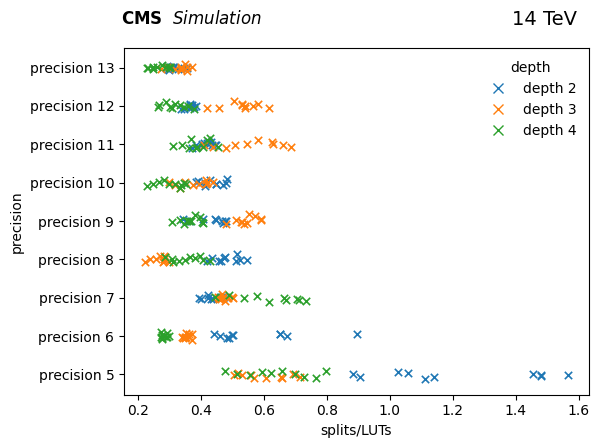

In [63]:
dff = dff[dff['splits'] > 0].copy()
dff['depth'] = dff['depth'].astype(int)
dff['precision'] = dff['precision'].astype(int)  # if not already ints
dff['coef']  = dff['splits'] / dff['LUT']

# Unique levels (SWAPPED)
precisions = sorted(dff['precision'].unique())   # now used for y-axis
depths     = sorted(dff['depth'].unique())       # now used for colors

# Color per depth (SWAPPED)
cycle_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
depth_to_color = {d: cycle_colors[i % len(cycle_colors)] for i, d in enumerate(depths)}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

rng = np.random.default_rng(42)
jitter_scale = 0.06

for d in depths:
    sub = dff[dff['depth'] == d]
    yj  = sub['precision'] + rng.normal(0, jitter_scale, size=len(sub))  # jitter on precision
    ax.scatter(
        sub['coef'], yj,
        marker='x', s=28, linewidths=1.2,
        c=depth_to_color[d],
        label=f"depth {d}"
    )

# Y as categorical precisions
ax.set_yticks(precisions)
ax.set_yticklabels([f"precision {p}" for p in precisions])

# Legend: depths (colors)
depth_handles = [
    Line2D([], [], marker='x', linestyle='None', color=depth_to_color[d],
           markersize=7, label=f"depth {d}")
    for d in depths
]
ax.legend(handles=depth_handles, title='depth', loc='upper right', frameon=False)

# Labels & CMS text
ax.set_xlabel('splits/LUTs')
ax.set_ylabel('precision')
plt.subplots_adjust(top=0.88)
fig.text(0.12, 0.965, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.965, "14 TeV",              ha="right", va="top", fontsize=14)

ax.grid(False)
plt.show()

/tmp/ipykernel_3213895/3949273658.py:22: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_3213895/3949273658.py:22: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_3213895/3949273658.py:22: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_3213895/3949273658.py:22: UserWarning: You passed a edgecolor/edgecolors ((0.90

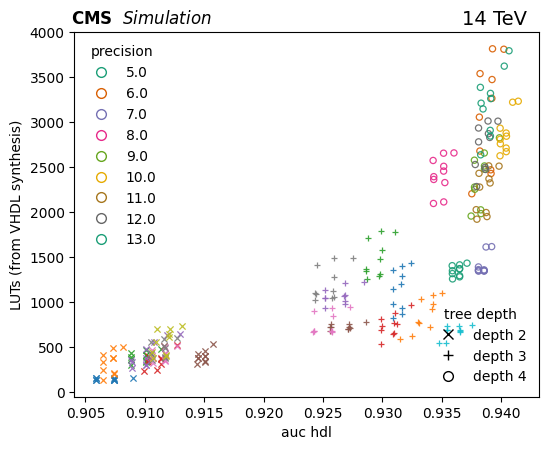

In [64]:
dff = df.dropna(subset=['LUT', 'auc_hdl', 'depth', 'precision']).copy()
dff['depth'] = dff['depth'].astype(int)

# --- Markers per DEPTH ---
depths = sorted(dff['depth'].unique())
marker_cycle = cycle(['x', '+', 'o', 'D', 's', '^', 'v', '>', '<', 'P', 'h'])
depth_to_marker = {d: next(marker_cycle) for d in depths}

# --- COLORS per PRECISION (use a big palette to avoid repeats) ---
precisions = sorted(dff['precision'].unique())
palette = plt.get_cmap('Dark2').colors  # more distinct colors than default cycle
color_cycle = cycle(palette)
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

for d, g_d in dff.groupby('depth'):
    mk = depth_to_marker[d]
    for p, g_dp in g_d.groupby('precision'):
        col = prec_to_color[p]
        ax.scatter(
            g_dp['auc_hdl'], g_dp['LUT'],
            s=20,
            marker=mk,
            edgecolors=col,                       # color encodes precision
            facecolors='none' if mk in ['o','D','s','^','v','>','<','P','h'] else None,
            linewidths=0.9,
            alpha=0.9
        )

# --- Legends ---
# Precision legend (colors)
prec_handles = [
    Line2D([], [], marker='o', linestyle='None',
           markerfacecolor='none', markeredgecolor=prec_to_color[p],
           markersize=7, label=str(p))
    for p in precisions
]
leg1 = ax.legend(handles=prec_handles, title='precision', loc='upper left', frameon=False)
ax.add_artist(leg1)

# Depth legend (markers)
depth_handles = [
    Line2D([], [], marker=depth_to_marker[d], linestyle='None',
           markerfacecolor='none' if depth_to_marker[d] in ['o','D','s','^','v','>','<','P','h'] else None,
           markeredgecolor='black', markersize=7, label=f"depth {d}")
    for d in depths
]
ax.legend(handles=depth_handles, title='tree depth', loc='lower right', frameon=False)

# --- Labels & CMS text ---
ax.set_xlabel('auc hdl')
ax.set_ylabel('LUTs (from VHDL synthesis)')
plt.subplots_adjust(top=0.92)
fig.text(0.12, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)

plt.show()

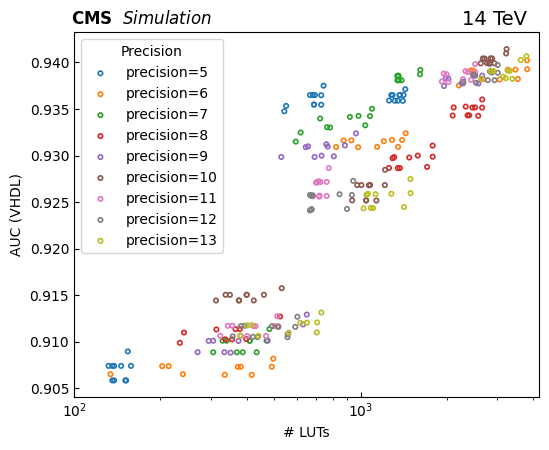

In [65]:
try:
    dff["precision"] = dff["precision"].astype(int)
except Exception:
    pass

# --- Colors per precision ---
precisions = sorted(dff["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

for p in precisions:
    sub = dff[dff["precision"] == p]
    ax.scatter(
        sub["LUT"],
        sub["auc_hdl"],
        label=f"precision={p}",
        s=10,
        facecolors="none",          # <-- hollow markers
        edgecolors=prec_to_color[p],
        linewidths=1.2
    )
import matplotlib.ticker as mticker

ax.set_xscale('log')

# show majors at 1, 10, 10^2, 10^3, ...
xmin = 100
xmax = float(dff["LUT"].max()) * 1.1
ax.set_xlim(xmin, xmax)

ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0, numticks=12))
ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext(base=10))
ax.xaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=range(2,10)))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_xlabel("# LUTs")
ax.set_ylabel("AUC (VHDL)")
ax.set_xscale("log")
ax.legend(title="Precision")#, ncol=2, frameon=False)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
fig.text(0.12, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_p016_plots/luts_vs_auc_per_precision.pdf")
plt.show()

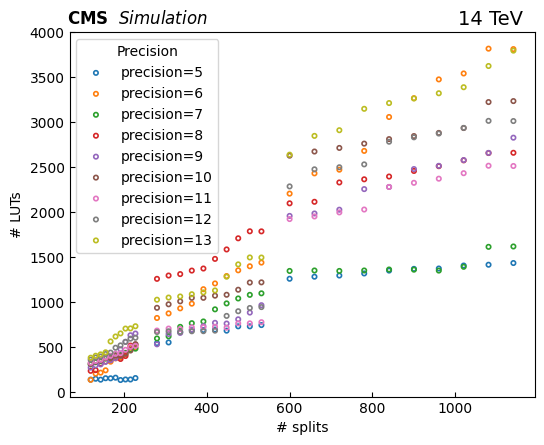

In [66]:
dff = df.dropna(subset=["splits", "LUT", "precision"]).copy()

try:
    dff["precision"] = dff["precision"].astype(int)
except Exception:
    pass

# --- Colors per precision ---
precisions = sorted(dff["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

for p in precisions:
    sub = dff[dff["precision"] == p]
    ax.scatter(
        sub["splits"],
        sub["LUT"],
        label=f"precision={p}",
        s=10,
        facecolors="none",          # <-- hollow markers
        edgecolors=prec_to_color[p],
        linewidths=1.2
    )

ax.set_ylabel("# LUTs")
ax.set_xlabel("# splits")
#ax.set_xscale("log")
ax.legend(title="Precision")#, ncol=2, frameon=False)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
fig.text(0.12, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_p016_plots/luts_vs_splits_per_precision.pdf")
plt.show()

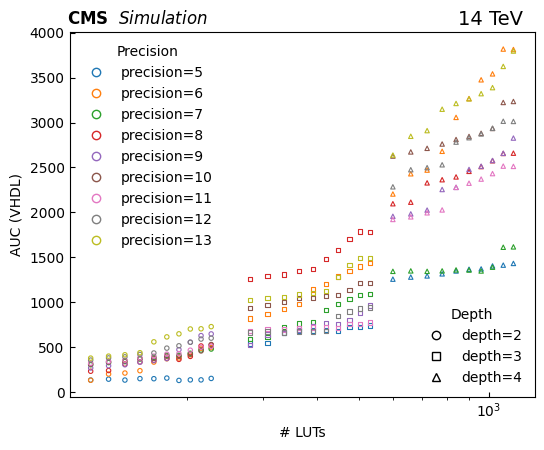

In [67]:
for col in ["precision", "depth"]:
    try:
        dff[col] = dff[col].astype(int)
    except Exception:
        pass

# --- Colors per precision ---
precisions = sorted(dff["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Markers per depth (all hollow-friendly) ---
depths = sorted(dff["depth"].unique())
marker_cycle = cycle(['o', 's', '^', 'v', '>', '<', 'P', 'X', 'h'])
depth_to_marker = {d: next(marker_cycle) for d in depths}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

# Plot grouped by (precision, depth)
for (p, d), sub in dff.groupby(["precision", "depth"]):
    ax.scatter(
        sub["splits"],
        sub["LUT"],
        s=10,
        facecolors="none",                         # hollow markers
        edgecolors=prec_to_color[p],              # color encodes precision
        marker=depth_to_marker[d],                # shape encodes depth
        linewidths=0.8,
        label=None
    )

ax.set_xlabel("# LUTs")
ax.set_ylabel("AUC (VHDL)")
ax.set_xscale("log")
ax.tick_params(direction='in')

# --- Dual legends: Precision (colors) + Depth (markers) ---
prec_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor=prec_to_color[p], label=f"precision={p}")
    for p in precisions
]
depth_handles = [
    Line2D([0], [0], marker=depth_to_marker[d], linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor='black', label=f"depth={d}")
    for d in depths
]

leg1 = ax.legend(handles=prec_handles, title="Precision", loc="upper left", frameon=False)
ax.add_artist(leg1)
ax.legend(handles=depth_handles, title="Depth", loc="lower right", frameon=False)

plt.subplots_adjust(top=0.92)
fig.text(0.12, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_p016_plots/luts_vs_auc_per_precision_per_depth.pdf")
plt.show()

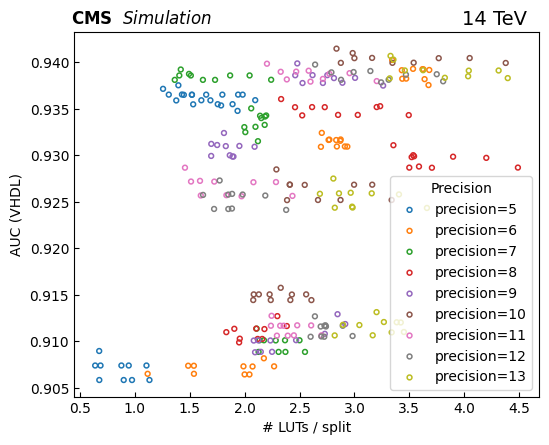

In [68]:
dff = dff[dff["splits"] > 0]                 # guard against div-by-zero
dff["precision"] = dff["precision"].astype(int)
dff["LUT_per_split"] = dff["LUT"] / dff["splits"]

# --- Colors per precision ---
precisions = sorted(dff["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4.5))

for p in precisions:
    sub = dff[dff["precision"] == p]
    ax.scatter(
        sub["LUT_per_split"],
        sub["auc_hdl"],
        label=f"precision={p}",
        s=12,
        facecolors="none",                 # hollow markers
        edgecolors=prec_to_color[p],
        linewidths=1.1
    )

ax.set_xlabel("# LUTs / split")
ax.set_ylabel("AUC (VHDL)")
ax.legend(title="Precision")
ax.tick_params(direction='in')

plt.subplots_adjust(top=0.92)
fig.text(0.12, 0.97, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.88, 0.97, "14 TeV", ha="right", va="top", fontsize=14)
plt.savefig("newsamples_p016_plots/luts_by_split_per_precision.pdf")

plt.show()